In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan


In [2]:
from filter_data import *

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [3]:
from load_and_clean import *

update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'North Macedonia', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Taiwan*', 'Syria', 'West Bank and Gaza', 'Saint Kitts and Nevis', 'Burma', 'MS Zaandam', 'Western Sahara']
These countries/region do not have population data ['Anchorage-Alaska', 'Joplin-Missouri', 'Kansas City-Missouri', 'Unknown-Alaska', 'Unknown-Arizona', 'Unknown-Arkansas', 'Unknown-California', 'Unknown-Colorado', 'Unknown-Connecticut', 'Unknown-Delaware', 'Unknown-Florida', 'Unknown-Georgia', 'Unknown-Guam', 'Unknown-Hawaii', 'Unknown-Idaho', 'Unknown-Illinois', 'Unknown-Indiana', 'Unknown-Iowa', 'Unknown-Kansas', 'Unknown-Kentucky', 'Unknown-Louisiana', 'Unknown-Maine', 'Unknown-Maryland', 'Unknown-Massachusetts', 'Unknown-Mich

In [4]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1)  
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1) 
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1)
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1)
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

last date
Exceptions are []


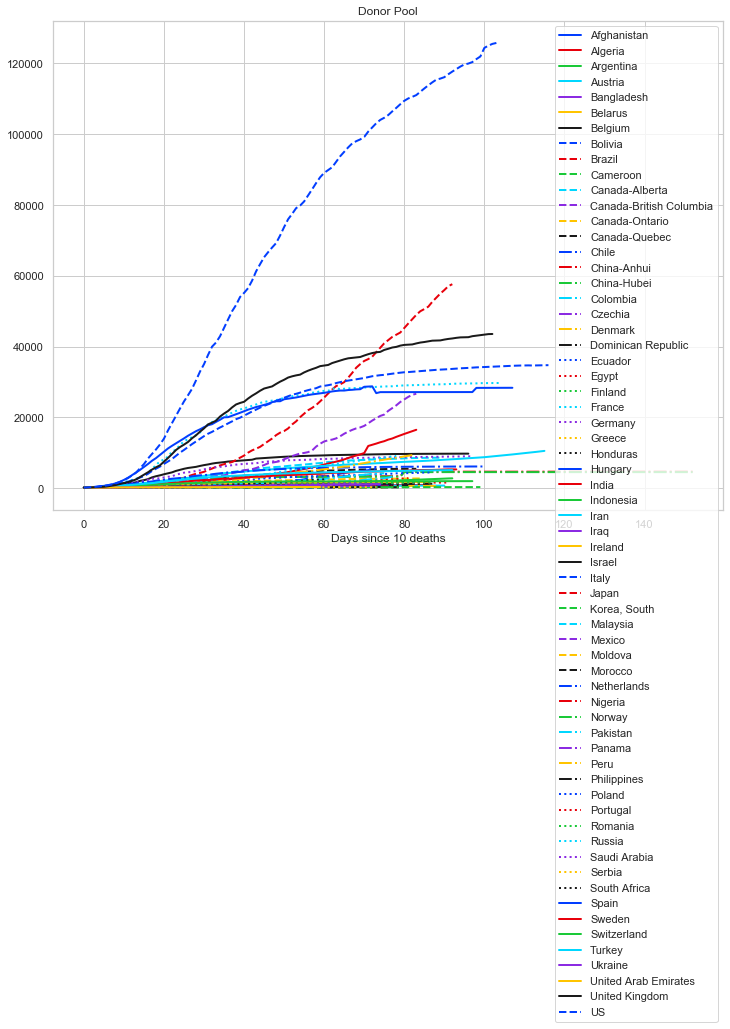

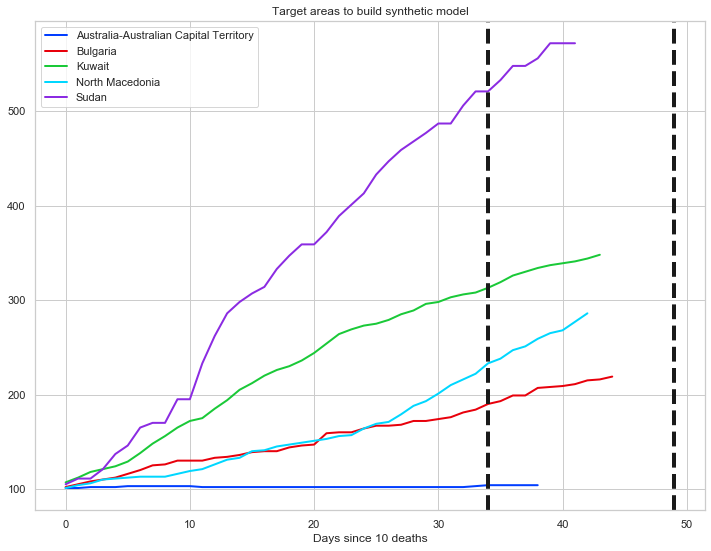

In [5]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})

global_deaths_filtered = create_filtered_data(global_deaths, 100 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=35
threshold=50
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)


plt.show()


In [6]:
rolling_average_duration = 7

daily_global_raw = create_rolling_data(create_filtered_data(global_deaths,5),rolling_average_duration)

daily_us_raw = create_rolling_data(create_filtered_data(usdeaths,5),rolling_average_duration)
daily_uscounties_raw = create_rolling_data(create_filtered_data(uscounties_deaths,5),rolling_average_duration)


In [7]:
from get_social_distancing import *
print(sd_data.columns)
intervention_tried = sd_data.columns[7]


Index(['name', 'country', 'admin1', 'Mass gathering restrictions',
       'Stay at Home Order', 'Educational facilities closed',
       'Initial business closures', 'Non-essential services closed',
       'Travel severely limited', 'Source Mass gathering restrictions',
       'Source Stay at Home Order', 'Source Educational facilities closed',
       'Source Initial business closure',
       'Source Non-essential services closed',
       'Source Travel severely limited', 'last date'],
      dtype='object')


In [8]:
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

last date
Exceptions are []


In [9]:

all_data = pd.concat([global_deaths, usdeaths], axis=1)  
all_data = pd.concat([all_data, uscounties_deaths], axis=1)

all_data_daily = create_rolling_data(all_data)
all_data_cases = pd.concat([global_cases, uscases], axis=1) 

all_data_cases = pd.concat([all_data_cases, uscounties_cases], axis=1)


all_data_cases_daily =create_rolling_data(all_data_cases)

In [10]:
newdf, _=filter_data_by_intervention(usdeaths, educational_distancing)
newdf_global,_=filter_data_by_intervention(global_deaths, educational_distancing)
newdf_uscounties,_=filter_data_by_intervention(uscounties_deaths, educational_distancing)

Italy -1 4.174296676105964
Italy -2 2.8221890010574877
Italy -3 3.507901585006626
United Kingdom -1 37.26660621075895
United Kingdom -2 2.5557007324003997


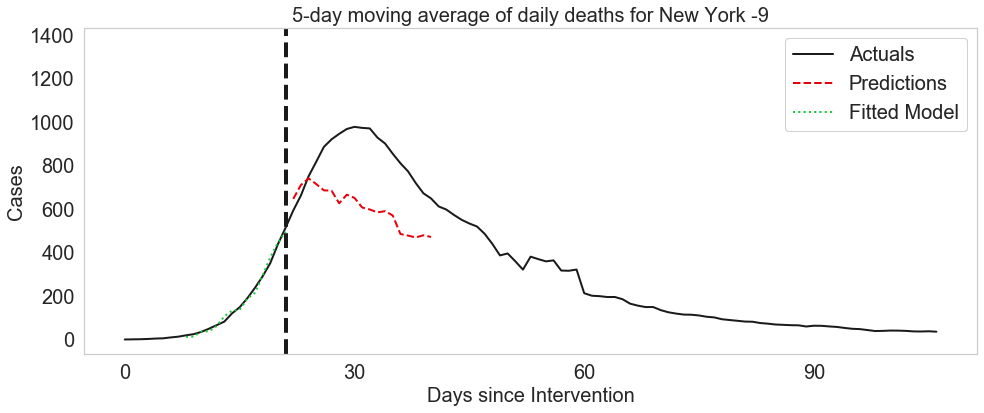

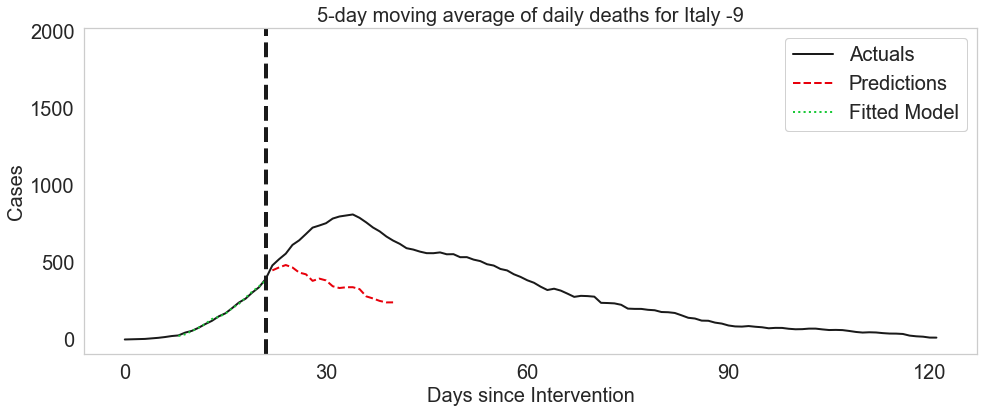

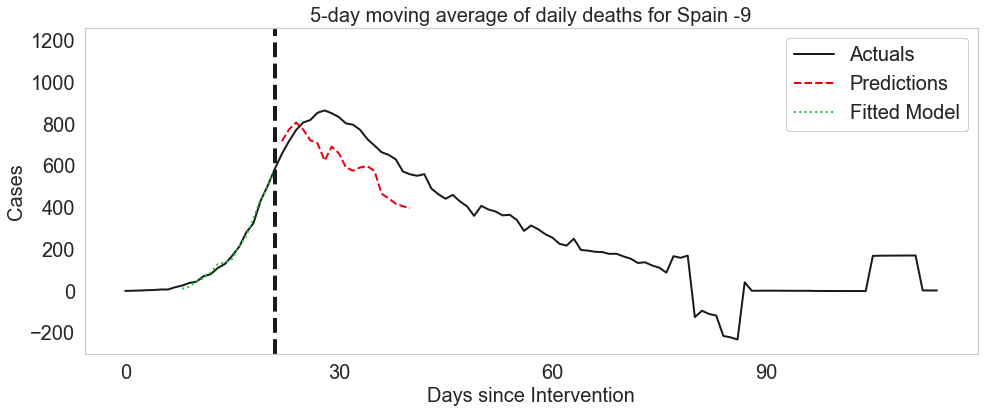

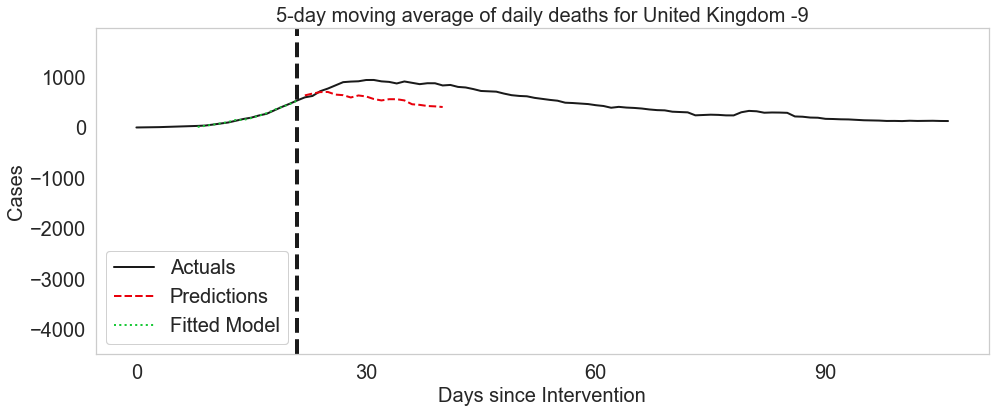

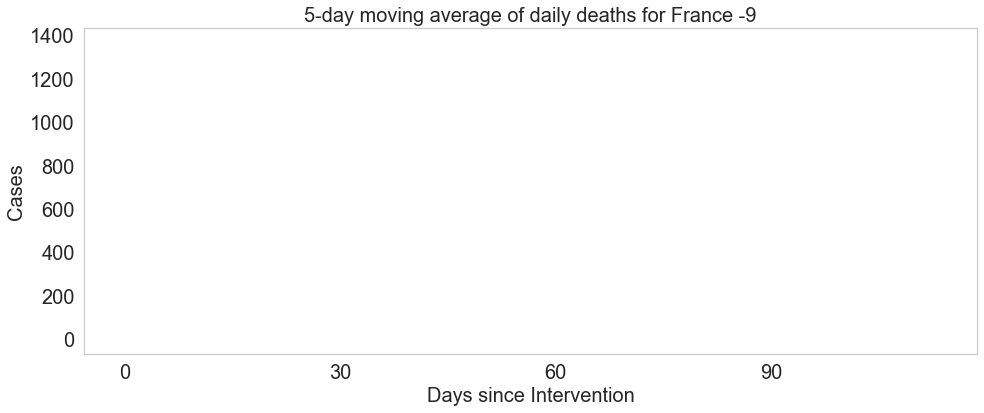

In [11]:

targets = ['New York', 'Italy', 'Spain', 'United Kingdom', 'France']

test, _ = filter_data_by_intervention(all_data_daily[targets], educational_distancing, 1)

singVals = 5

    

videos = []
for target in targets:
    fig, axes = plt.subplots(figsize=(16, 6))
    camera = Camera(fig)
    
    for i in range(1,10):
        temp_df,_= filter_data_by_intervention(all_data_daily[[target]], educational_distancing, i)

        # This has been made silent as to not flood the output
        return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 42,22, "5-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12,
                                   exclude=[target], animation=camera, figure=fig, axes=axes, showDonors=False, silent=True, showPlots=True)
    

    animation = camera.animate()
    videos.append(HTML(animation.to_html5_video()))

    
    #HTML(animation_final.to_jshtml())

    #animation_final.save('../animations/'+target+' no donors new.mp4')
display(*videos)

New York 1.0202859342257458
New York 1.0202859342257458
New Jersey 1.066396694749941
New Jersey 1.1235686295281238
France 1.036973686229957
France 2.3153063039082005
France 3.2887367503744107
Italy 2.4229941304003884
Italy 1.074694794321349


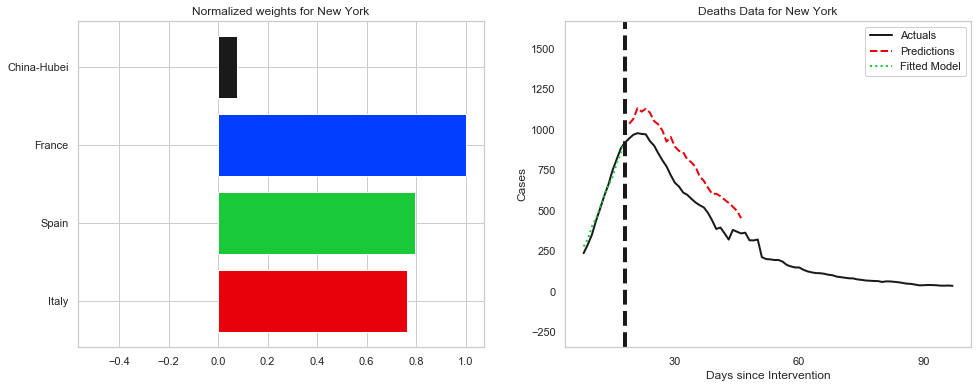

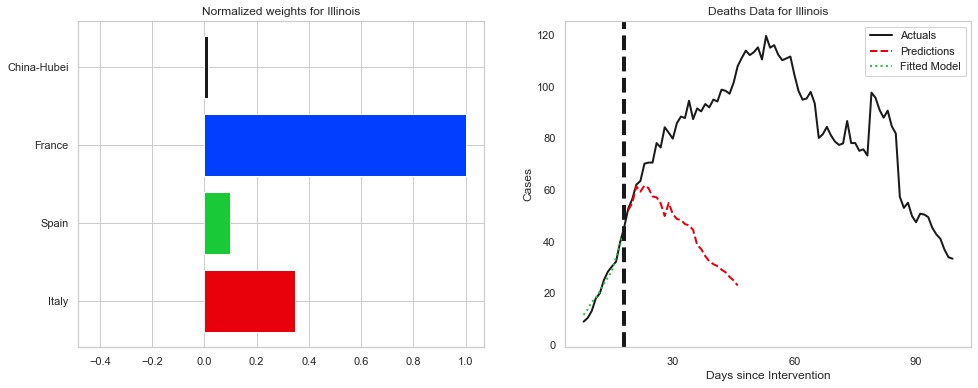

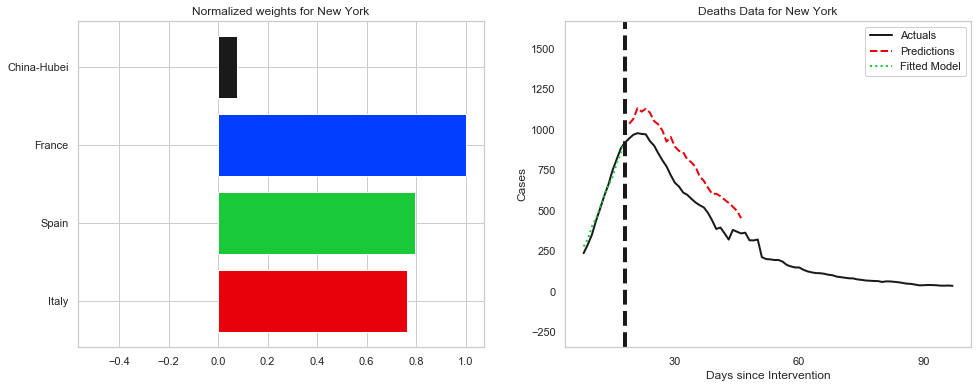

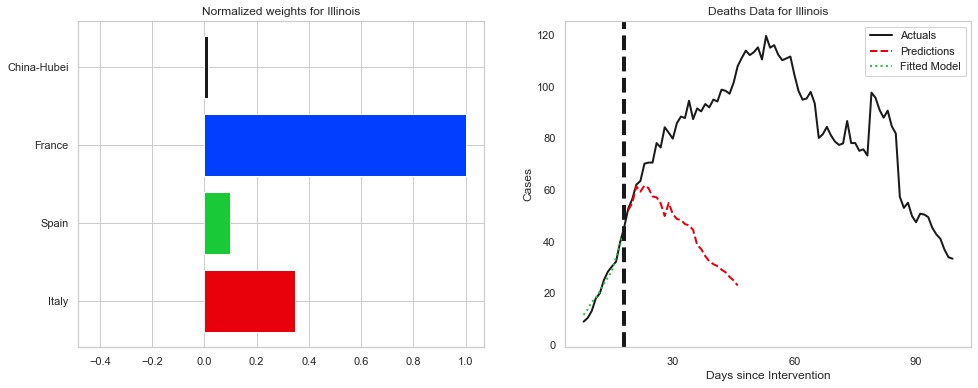

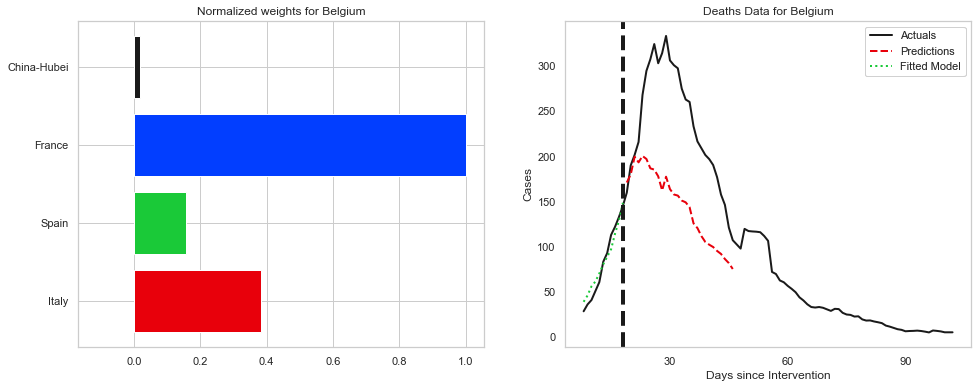

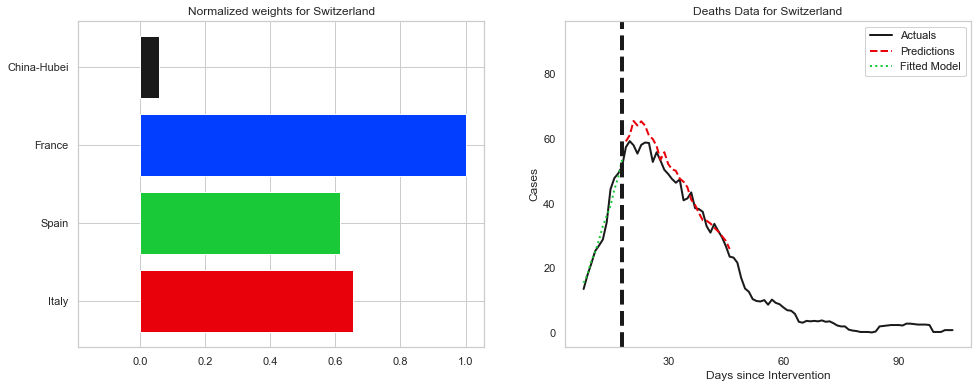

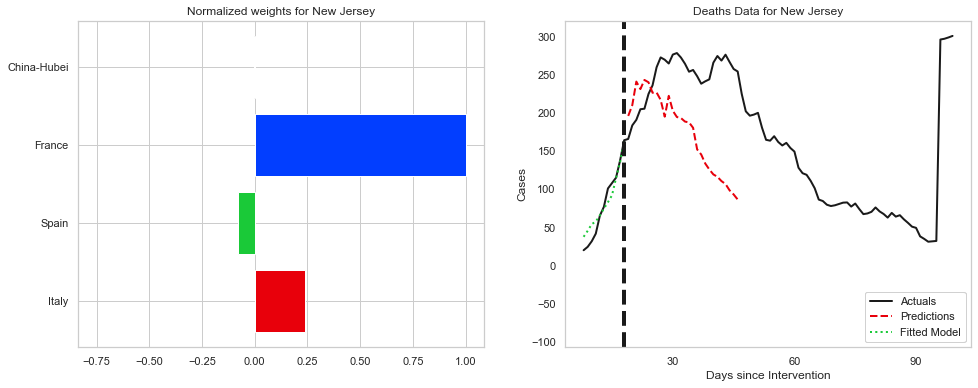

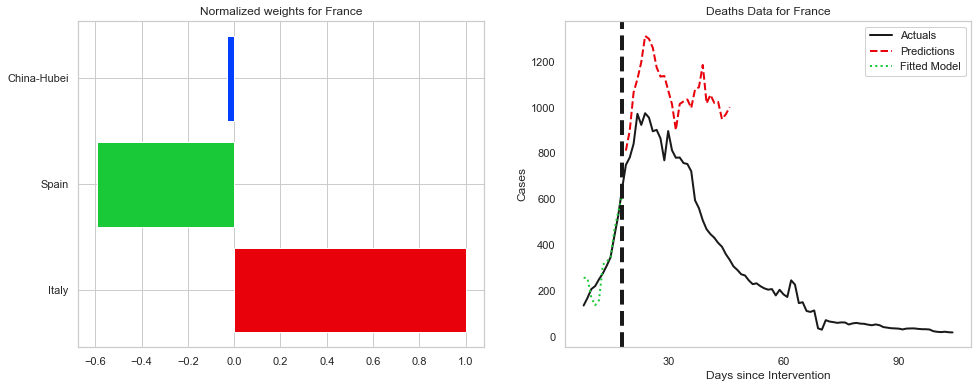

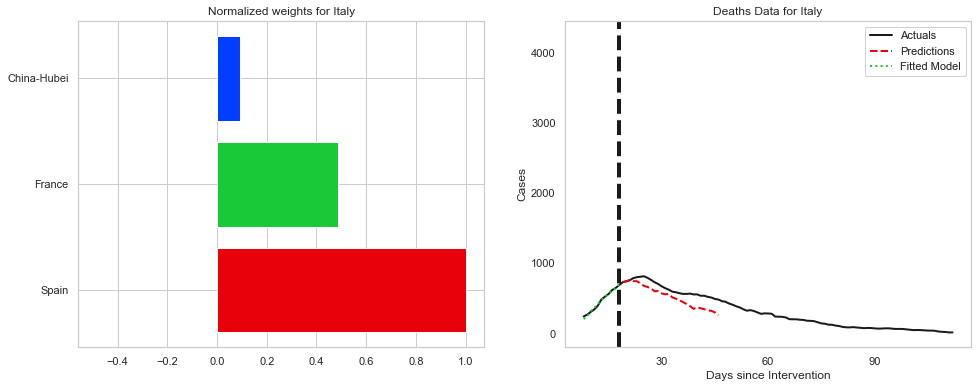

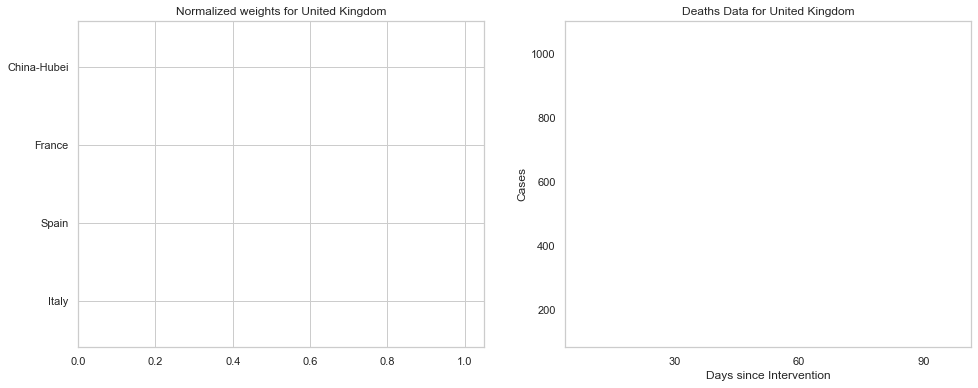

In [12]:
targets = ['New York', 'Illinois', 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
donorpool = ['Italy', 'Spain', 'France', 'China-Hubei']
singVals = 2

move_intervention = 10
videos = []
for target in targets:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    camera = Camera(fig)
    for i in range(1,10):
        # This has been made silent as to not flood the output
        new_value = synth_control_predictions([deaths_intervention_adjusted_daily],40,2+i, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, donorPool=donorpool, animation=camera, figure=fig, axes=axes, showDonors=True, silent=True )
    animation = camera.animate(interval=300)
    videos.append(HTML(animation.to_html5_video()))
#animation.save('../animations/'+target+' predictions.mp4')
#temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, move_intervention)
        #synth_control_predictions(pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1),45,25, "Deaths Data", 
                              #singVals, ylimit=[], savePlots=False, do_only=[target+" -"+str(move_intervention)], 
                              # showstates=10, svdSpectrum=False, showDonors=False,
                              # exclude=[target])
display(*videos)

In [13]:
df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
lambdas=[1,0.01]
df1 = cases_intervention_adjusted_daily[df.columns].iloc[15:,:].copy()

#targets = [ 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#targets = newdf.columns
high_thresh = 55
low_thresh = 50
#targets = random.sample(list(deaths_intervention_adjusted_daily.columns),80)
targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index


donorpool = sizes[sizes>=high_thresh].index


print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([df, df1],high_thresh, low_thresh,
                                            "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, silent=True, showDonors=False, showPlots=False, lambdas=lambdas, mRSC=False, error_thresh = 1)
        weight_features.append(newdata)
    except ValueError:
        print(target)
        continue
feature_list = pd.DataFrame((weight_features))
feature_list.index=targets
feature_list.fillna(0, inplace=True)
#feature_list = feature_list.apply(lambda x: x/x.max(), axis=1)
feature_columns = feature_list.columns
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(feature_list[feature_columns])
feature_list.insert((feature_list.shape[1]),'KMeans',y)
feature_list.groupby('KMeans').groups
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_method='leaf')
clustering_labels = clusterer.fit_predict(feature_list[feature_columns])
feature_list['DB'] = clustering_labels
feature_list.groupby('DB').groups


Index(['Austria', 'Belgium', 'China-Hubei', 'Czechia', 'Denmark', 'Finland',
       'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy',
       'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'Alabama', 'Arizona', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Illinois', 'Indiana', 'Iowa', 'Louisiana',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'Ohio', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Texas',
       'Virginia', 'Washington', 'Wisconsin', 'King-Washington',
       'Los Angeles-California', 'New York City-New York'],
      dtype='object')
Index(['Austria', 'Belgium', 'China-Hubei', 'Czechia', 'Denmark', 'Finland',
       'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy',
       'Netherlands', 'Poland', 'Portugal',

{-1: Index(['Austria', 'Belgium', 'China-Hubei', 'France', 'Germany', 'India',
        'Ireland', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Spain',
        'Switzerland', 'United Kingdom', 'Connecticut', 'Illinois', 'Iowa',
        'Louisiana', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri',
        'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Pennsylvania',
        'Rhode Island', 'Washington', 'Wisconsin', 'Los Angeles-California',
        'New York City-New York'],
       dtype='object'),
 0: Index(['Sweden', 'California'], dtype='object'),
 1: Index(['Indiana', 'Maryland'], dtype='object'),
 2: Index(['Florida', 'Georgia', 'Texas'], dtype='object'),
 3: Index(['Romania', 'Arizona', 'Colorado', 'Minnesota', 'Virginia'], dtype='object'),
 4: Index(['Czechia', 'Denmark', 'Hungary', 'South Carolina', 'King-Washington'], dtype='object'),
 5: Index(['Alabama', 'New Mexico'], dtype='object'),
 6: Index(['Finland', 'Delaware', 'District of Columbia'], dtype='object')}

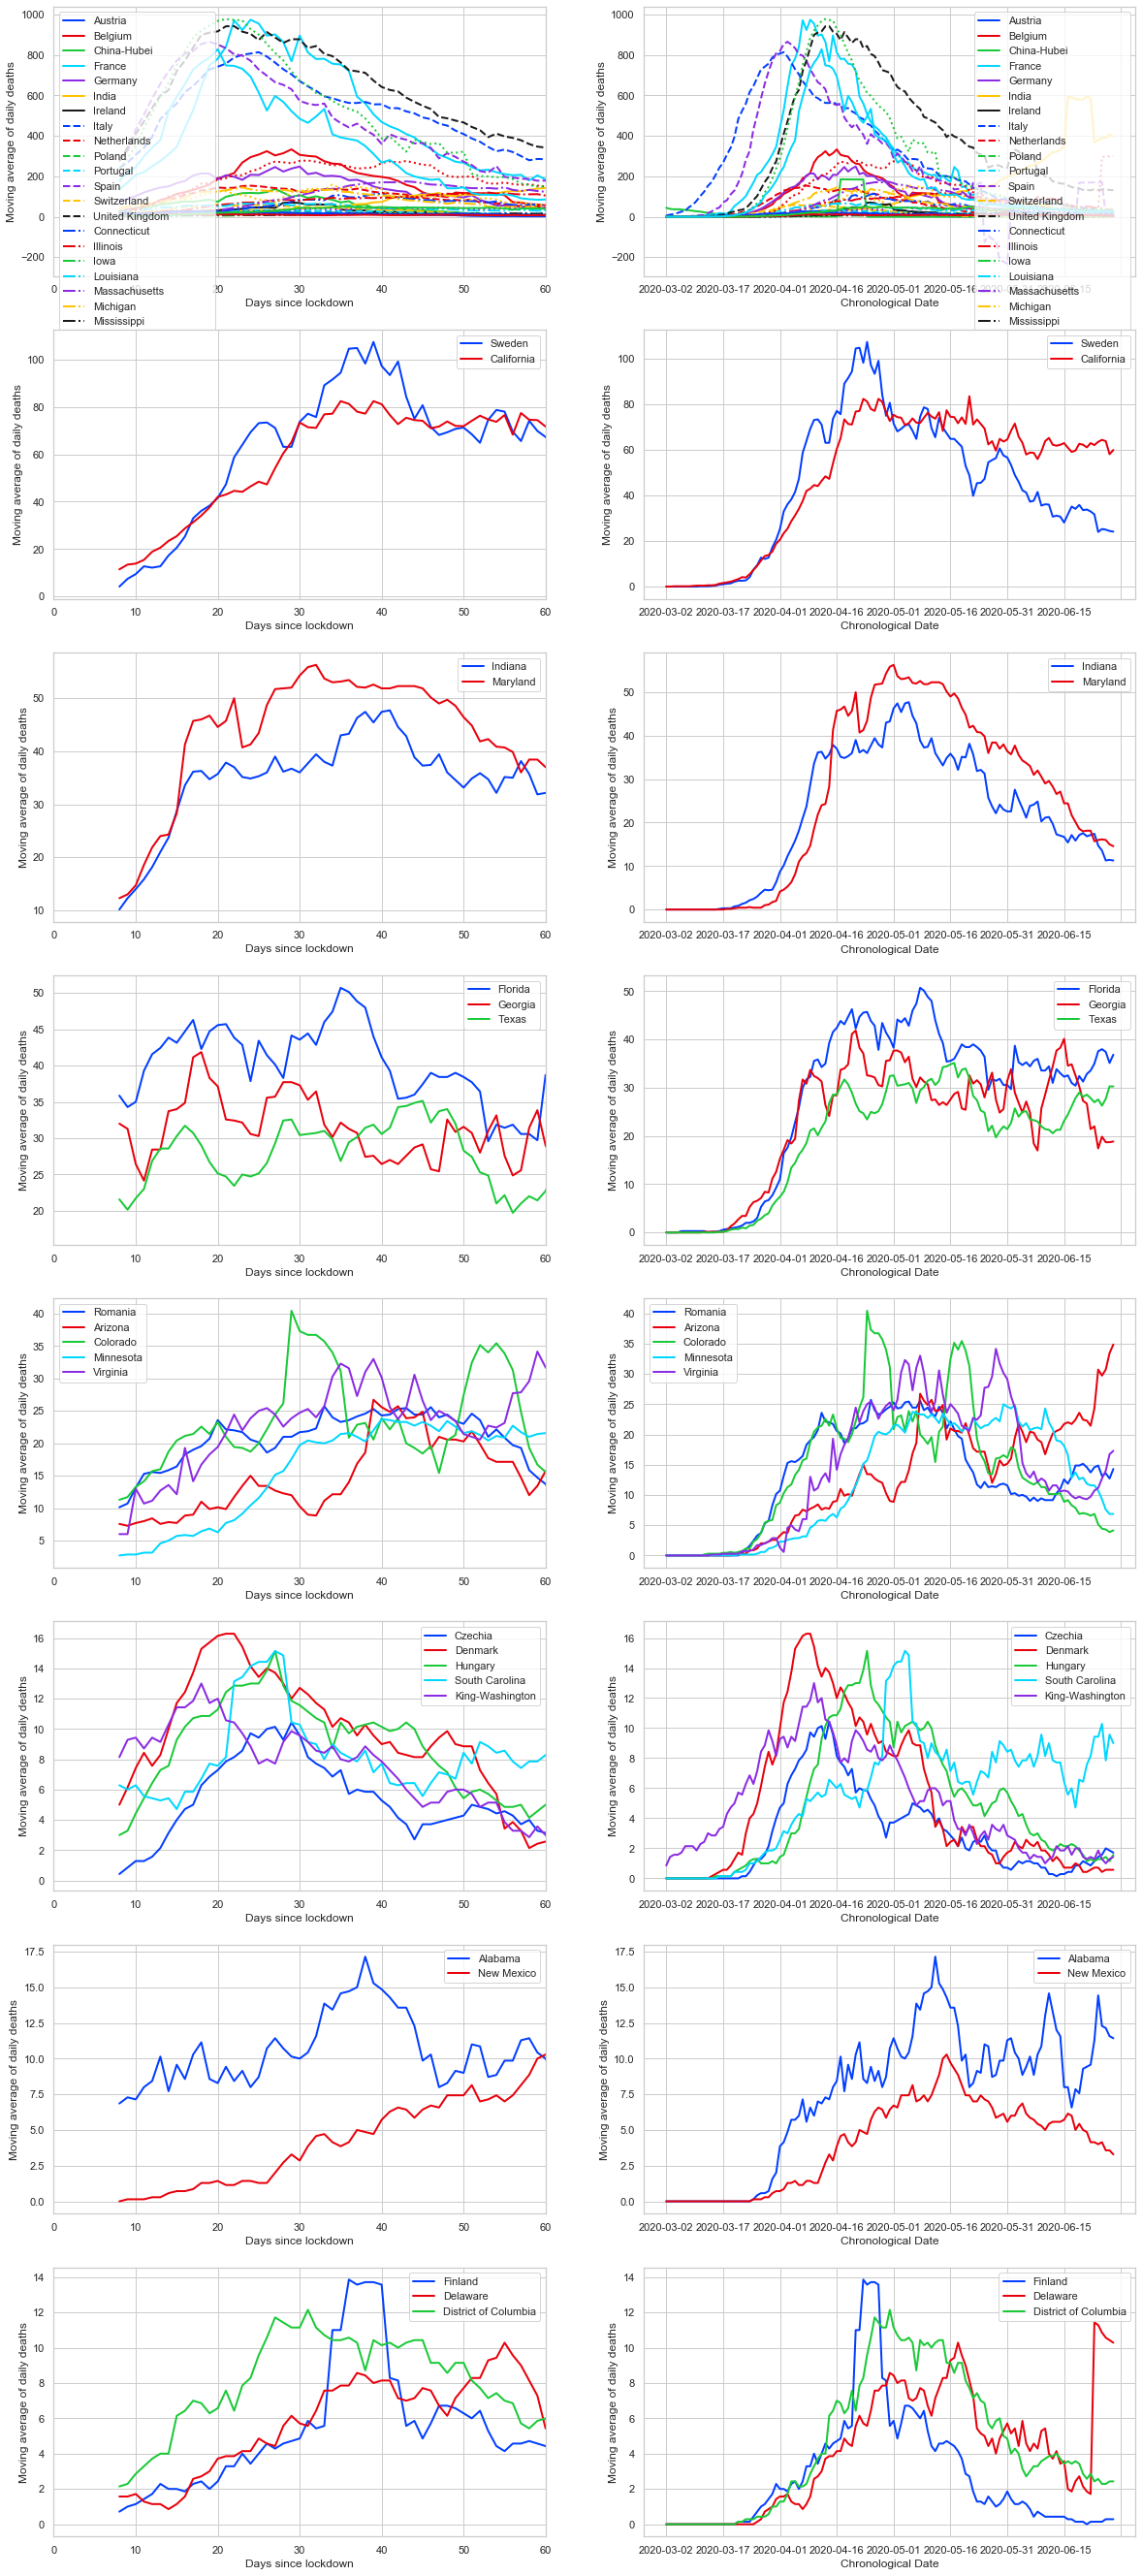

In [14]:
num_groups = len(feature_list.groupby('DB').groups)
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.figsize'] = (20.0, num_groups*6.0)
group1 = list(feature_list.groupby('DB').groups[-1])
for i in range(num_groups):
    group = (list(feature_list.groupby('DB').groups[i-1]))
    ax = plt.subplot(num_groups,2,2*i+1)

    df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')
    ax = plt.subplot(num_groups,2,2*i+2)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')

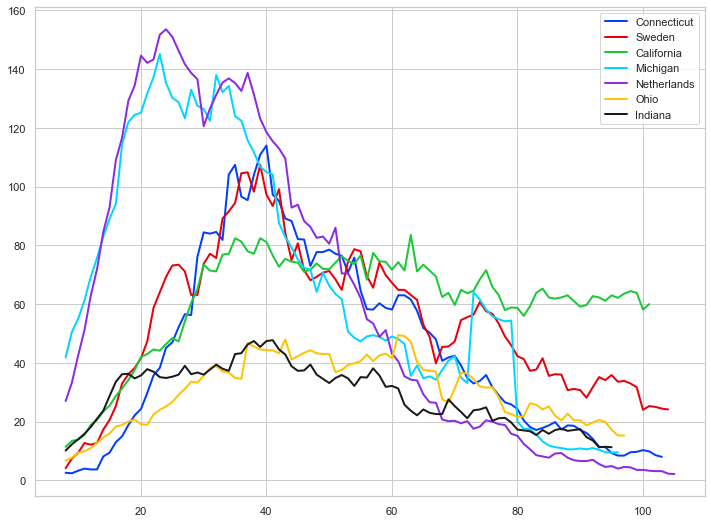

In [15]:
plt.rcParams['figure.figsize'] = (12,9.0)
plt.rcParams.update({'font.size': 12})


targets = ['Connecticut', 'Sweden', 'California', 'Michigan', 'Netherlands', 'Ohio', 'Indiana']
deaths_intervention_adjusted_daily[targets].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x120208910>,
 Text(0.5, 0, 'Chronological Date'),
 Text(0, 0.5, 'Moving average of daily deaths'))

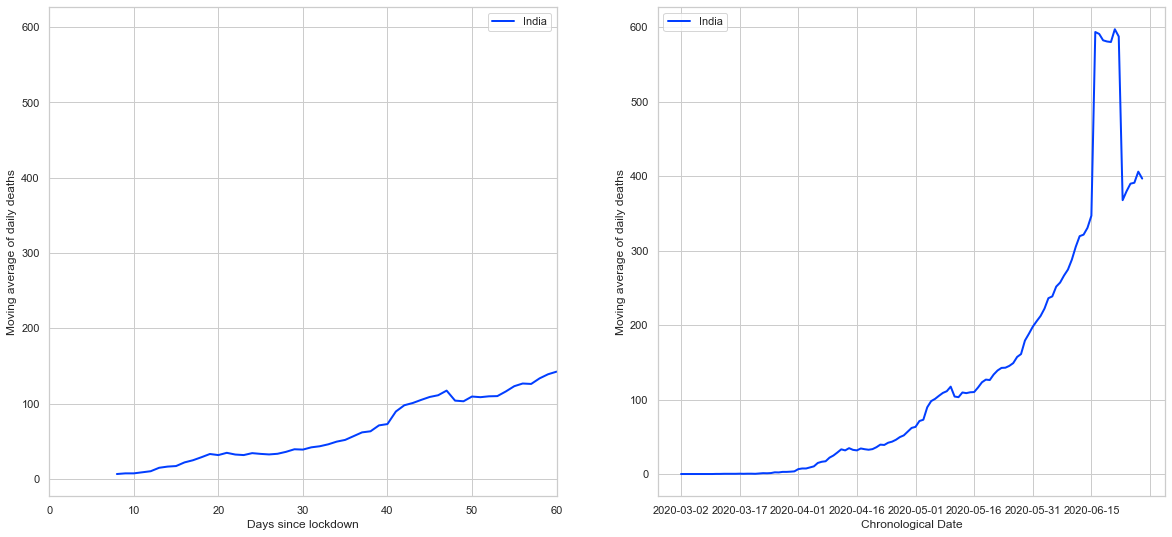

In [16]:
plt.rcParams['figure.figsize'] = (20,9.0)

group=['India']
ax = plt.subplot(1,2,1)

df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')
ax = plt.subplot(1,2,2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')

[1.125]


{-1: Index(['France'], dtype='object'),
 0: Index(['Austria', 'Belgium', 'China-Hubei', 'Czechia', 'Denmark', 'Finland',
        'Germany', 'Hungary', 'India', 'Ireland', 'Italy', 'Netherlands',
        'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden', 'Switzerland',
        'United Kingdom', 'Alabama', 'Arizona', 'California', 'Colorado',
        'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
        'Illinois', 'Indiana', 'Iowa', 'Louisiana', 'Maryland', 'Massachusetts',
        'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'New Jersey',
        'New Mexico', 'New York', 'North Carolina', 'Ohio', 'Pennsylvania',
        'Rhode Island', 'South Carolina', 'Texas', 'Virginia', 'Washington',
        'Wisconsin', 'King-Washington', 'Los Angeles-California',
        'New York City-New York'],
       dtype='object')}

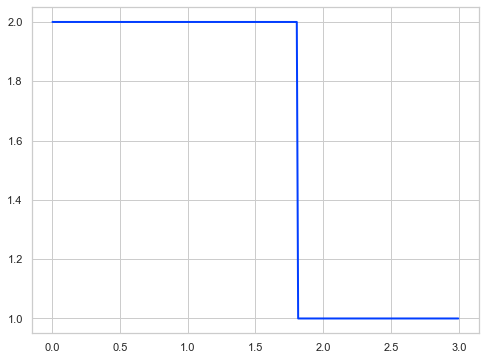

In [17]:
clusters = []
epsilon_range = np.arange(0.005,3,0.01)
for epsilon in epsilon_range:
    clustering = DBSCAN(eps=epsilon, min_samples=4).fit(feature_list[feature_columns].values)
    clusters.append(len(np.unique(clustering.labels_)))
plt.rcParams['figure.figsize'] = (8, 6)
plt.plot(epsilon_range, clusters)

eps = epsilon_range[np.argmax(clusters)]
eps = epsilon_range[random.choice(np.argwhere(clusters == np.amax(clusters)))]
print(eps)
#eps=.28
clustering = DBSCAN(eps=eps, min_samples=4).fit(feature_list[feature_columns].values)    
try:
    feature_list['DB'] = clustering.labels_
except KeyError:
    feature_list.insert((feature_list.shape[1]),'DB',clustering.labels_)
feature_list.groupby('DB').groups

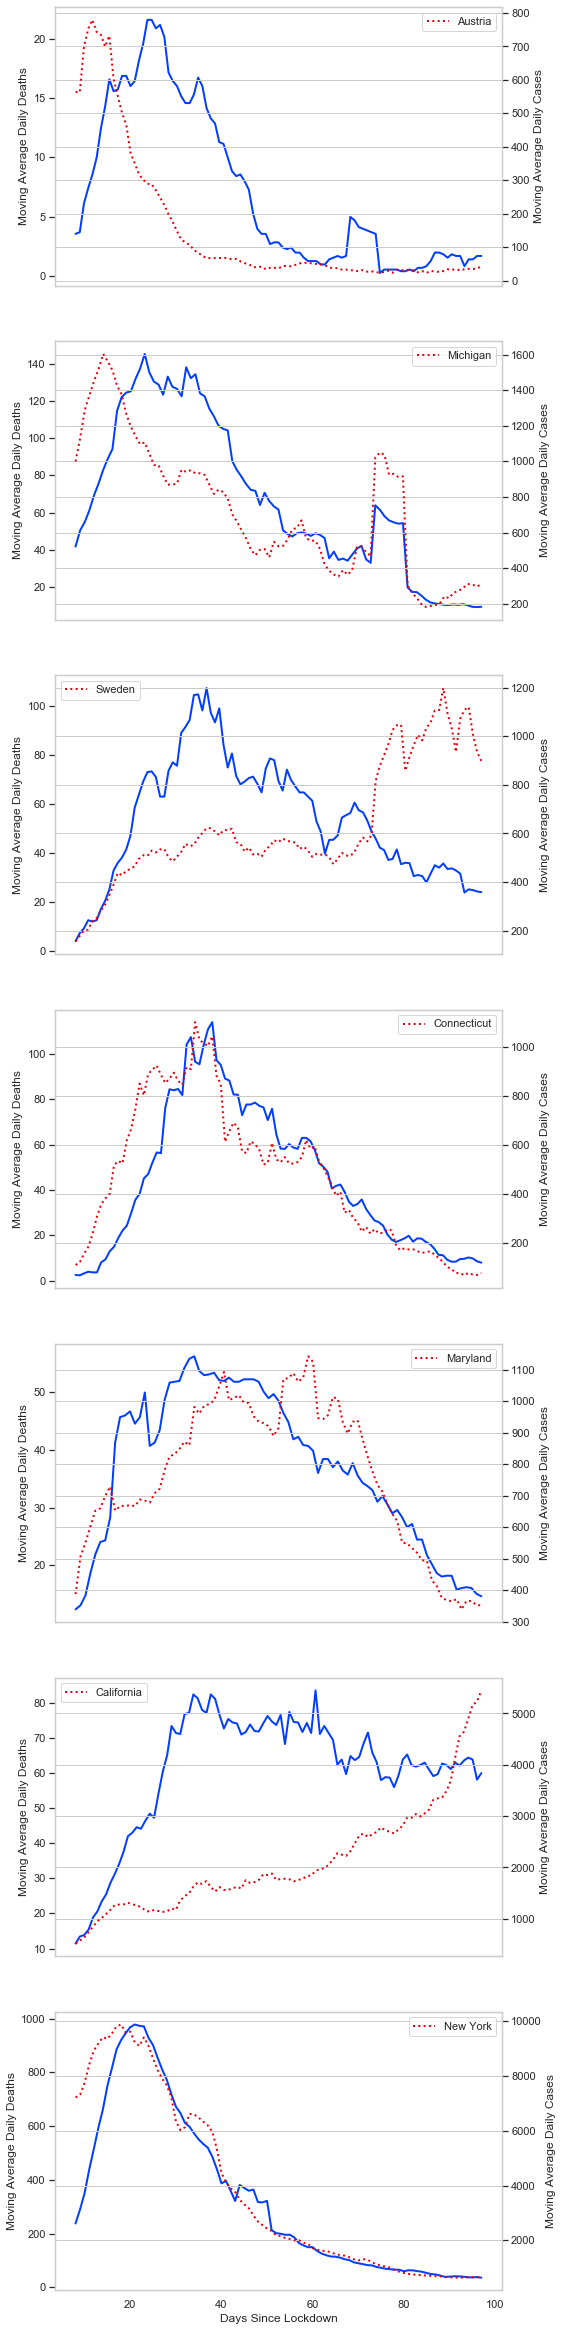

In [18]:
plt.rcParams.update({'font.size': 14})
list_of_clusters = ['Austria', 'Michigan', 'Sweden', 'Connecticut', 'Maryland', 'California', 'New York']
num_clusters = len(list_of_clusters)
plt.rcParams['figure.figsize'] = (8.0, num_clusters*6.0)

i=1
for clusters in list_of_clusters:
    ax = plt.subplot(num_clusters,1,i)
    deaths_intervention_adjusted_daily[clusters].plot(ax=ax), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths'), 
    cases_intervention_adjusted_daily[clusters].plot(ax=ax, linestyle=":", secondary_y=True), plt.ylabel('Moving Average Daily Cases'), plt.legend(),
    plt.xticks(rotation=45)
    i = i+1
                                                                                                

((array([ 0., 10., 20., 30., 40., 50., 60.]),
  <a list of 7 Text xticklabel objects>),
 Text(0.5, 0, 'Days Since Lockdown'),
 Text(0, 0.5, 'Moving Average Daily Deaths'))

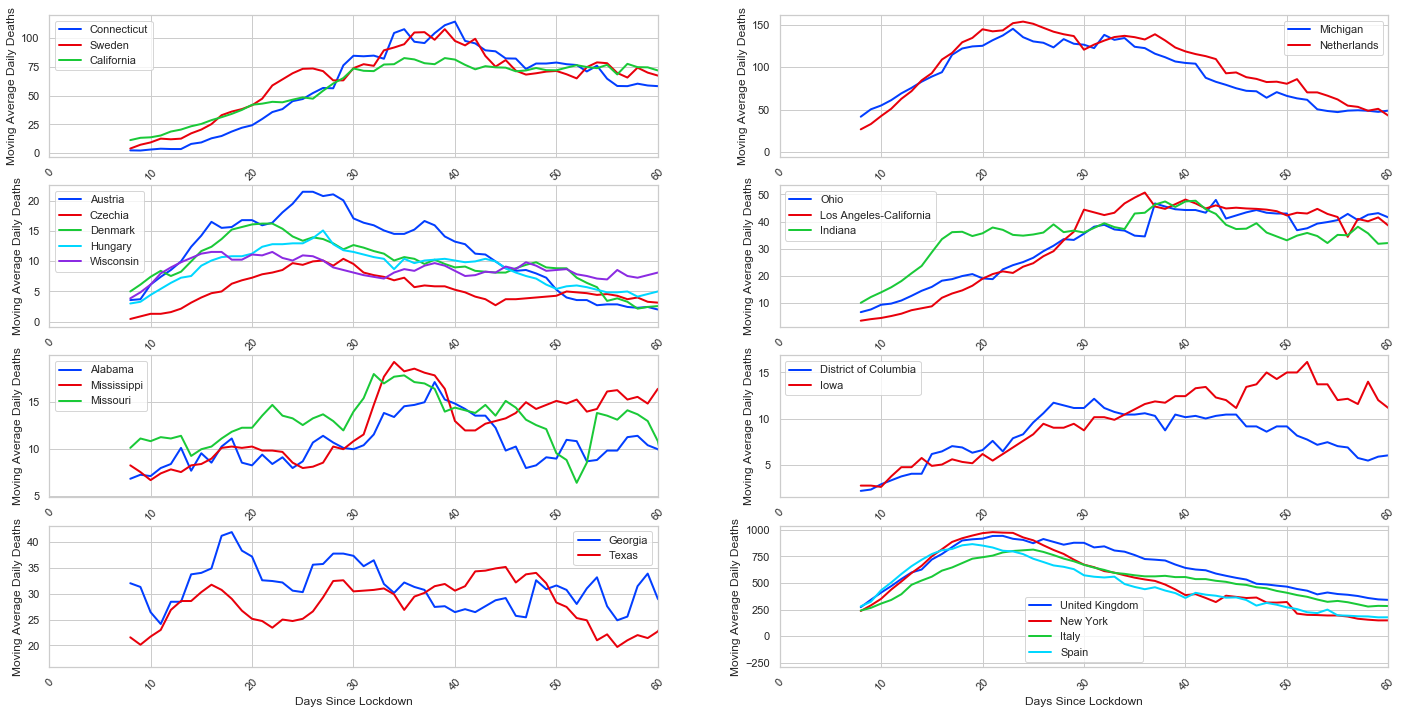

In [19]:
plt.rcParams['figure.figsize'] = (24.0, 12.0)
ax = plt.subplot(4,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden', 'California' ]].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,3)
deaths_intervention_adjusted_daily[['Austria', 'Czechia', 'Denmark', 'Hungary','Wisconsin']].plot(ax=ax), plt.xlim(0,60),

#deaths_intervention_adjusted_daily[['Ireland', 'Colorado']].plot(ax=ax), 

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California', 'Indiana']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

plt.plot()
ax = plt.subplot(4,2,5)

deaths_intervention_adjusted_daily[['Alabama', 'Mississippi', 'Missouri' ]].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,6)

deaths_intervention_adjusted_daily[['District of Columbia', 'Iowa']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,7)

deaths_intervention_adjusted_daily[['Georgia', 'Texas']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,8)

deaths_intervention_adjusted_daily[[ 'United Kingdom', 'New York', 'Italy', 'Spain']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

((array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
  <a list of 7 Text xticklabel objects>),
 Text(0.5, 0, 'Days Since Lockdown'),
 Text(0, 0.5, 'Moving Average Daily Deaths'))

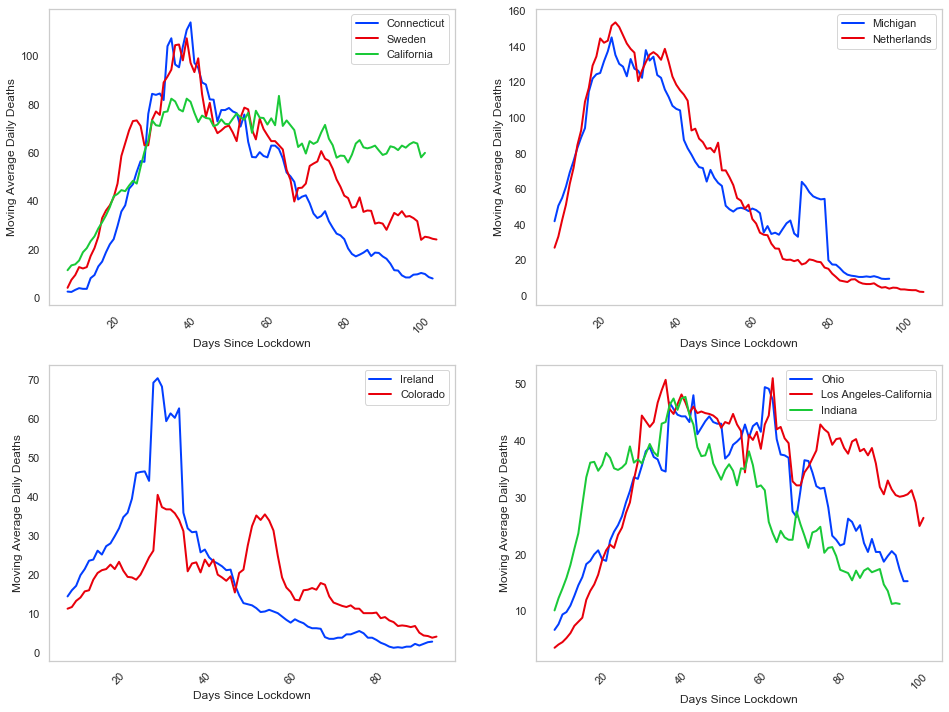

In [20]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
ax = plt.subplot(2,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden', 'California' ]].plot(ax=ax), plt.grid(),
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,3)

deaths_intervention_adjusted_daily[['Ireland', 'Colorado']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California', 'Indiana']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

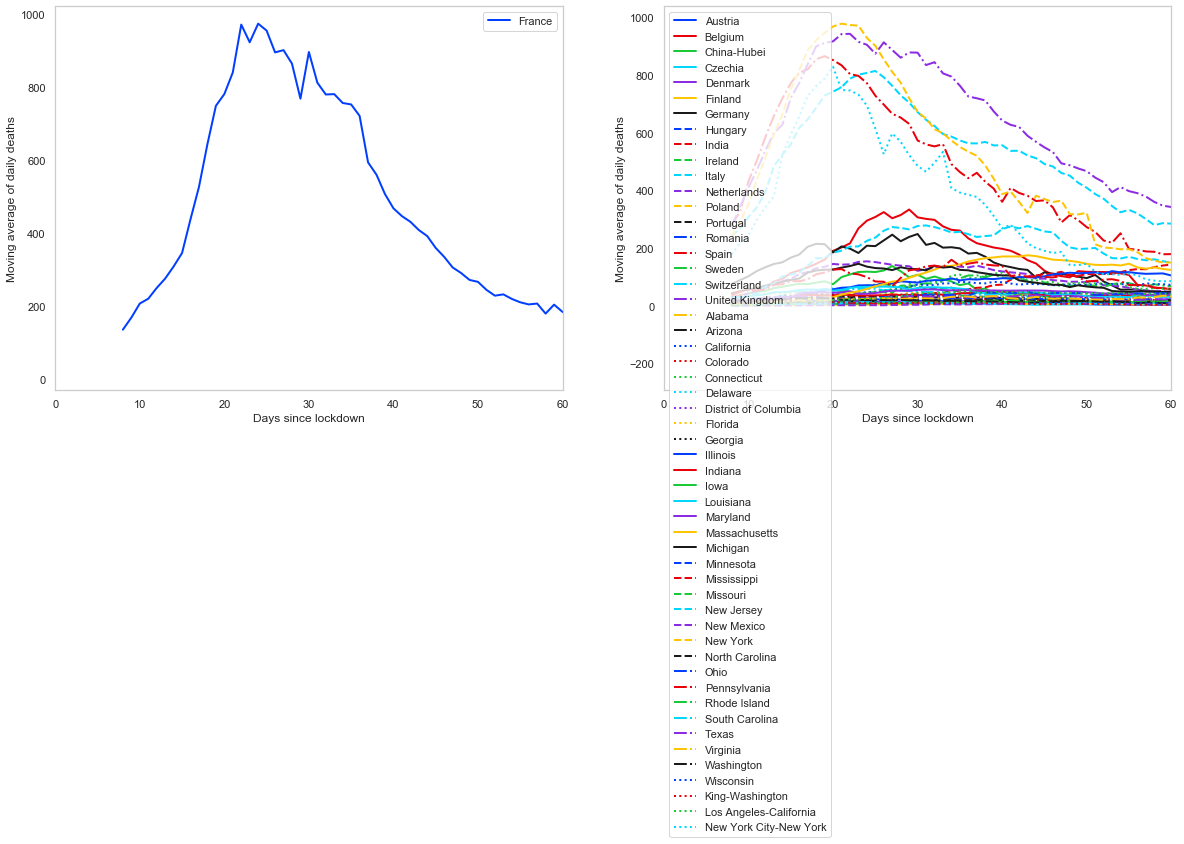

In [21]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = (20.0, 24.0)
plt.xlim([0,60])
for i in range(len(feature_list.groupby('DB').groups)):
    ax = plt.subplot(3,2,i+1)
    plt.xlim([0,60])
    group = (list(feature_list.groupby('DB').groups[i-1]))
    df[group].plot(ax = ax), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths'),plt.grid()

In [22]:
states = list(set(usstates['state'].values))
print(states)

['South Dakota', 'Nebraska', 'Missouri', 'Georgia', 'Kentucky', 'Vermont', 'Arkansas', 'Maryland', 'West Virginia', 'Puerto Rico', 'Virgin Islands', 'South Carolina', 'Delaware', 'Illinois', 'Rhode Island', 'Colorado', 'Mississippi', 'Wyoming', 'Hawaii', 'Tennessee', 'Washington', 'Virginia', 'District of Columbia', 'Indiana', 'Ohio', 'Minnesota', 'North Dakota', 'Texas', 'California', 'New York', 'Arizona', 'Oregon', 'Maine', 'Guam', 'North Carolina', 'Massachusetts', 'New Hampshire', 'Louisiana', 'Michigan', 'Nevada', 'Florida', 'Alaska', 'Idaho', 'Pennsylvania', 'Connecticut', 'Iowa', 'Montana', 'Northern Mariana Islands', 'Oklahoma', 'Kansas', 'Alabama', 'New Mexico', 'Wisconsin', 'Utah', 'New Jersey']


In [23]:
high_thresh = 40
low_thresh = 35
targets = usstates
#excludelist = group2.copy()

sizes = deaths_intervention_adjusted_daily[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>low_thresh].index
donorpool = sizes[sizes>high_thresh].index
print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([deaths_intervention_adjusted_daily[targets]],high_thresh, low_thresh,
                                            "Daily Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                              svdSpectrum=False, silent=True, showDonors=False, mRSC=False, showPlots=False)
        #newdata = synth_control_predictions(deaths_intervention_adjusted_daily,high_thresh, low_thresh,
        #                                    "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
        #                       exclude=excludelist, svdSpectrum=False, silent=False, showDonors=False, donorPool=group1 )
        
    except ValueError:
        print(target)
        continue


Index([], dtype='object')
Index([], dtype='object')


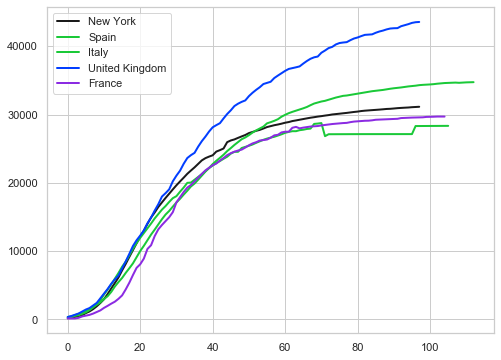

(Text(0.5, 0, 'Days since non-essential businesses shut down'),
 Text(0, 0.5, '5-day moving average of daily death count'),
 <matplotlib.legend.Legend at 0x123559eb0>)

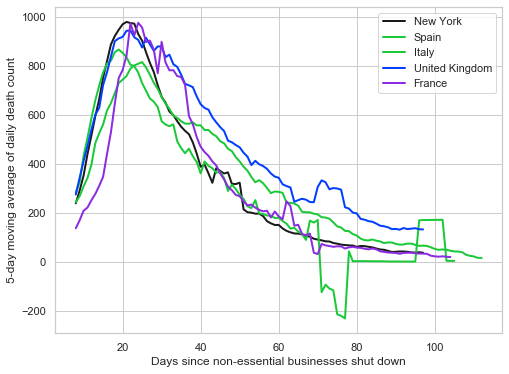

In [24]:
#plt.yscale('log')
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
plt.figure(figsize=(8,6))
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), daily_global['France'].plot(color='m'),
plt.xlabel('Days since non-essential businesses shut down'), plt.ylabel('5-day moving average of daily death count'), plt.legend()

([None, None, None, None, None, None, None, None, None, None, None, None],
 <matplotlib.legend.Legend at 0x12061d7f0>)

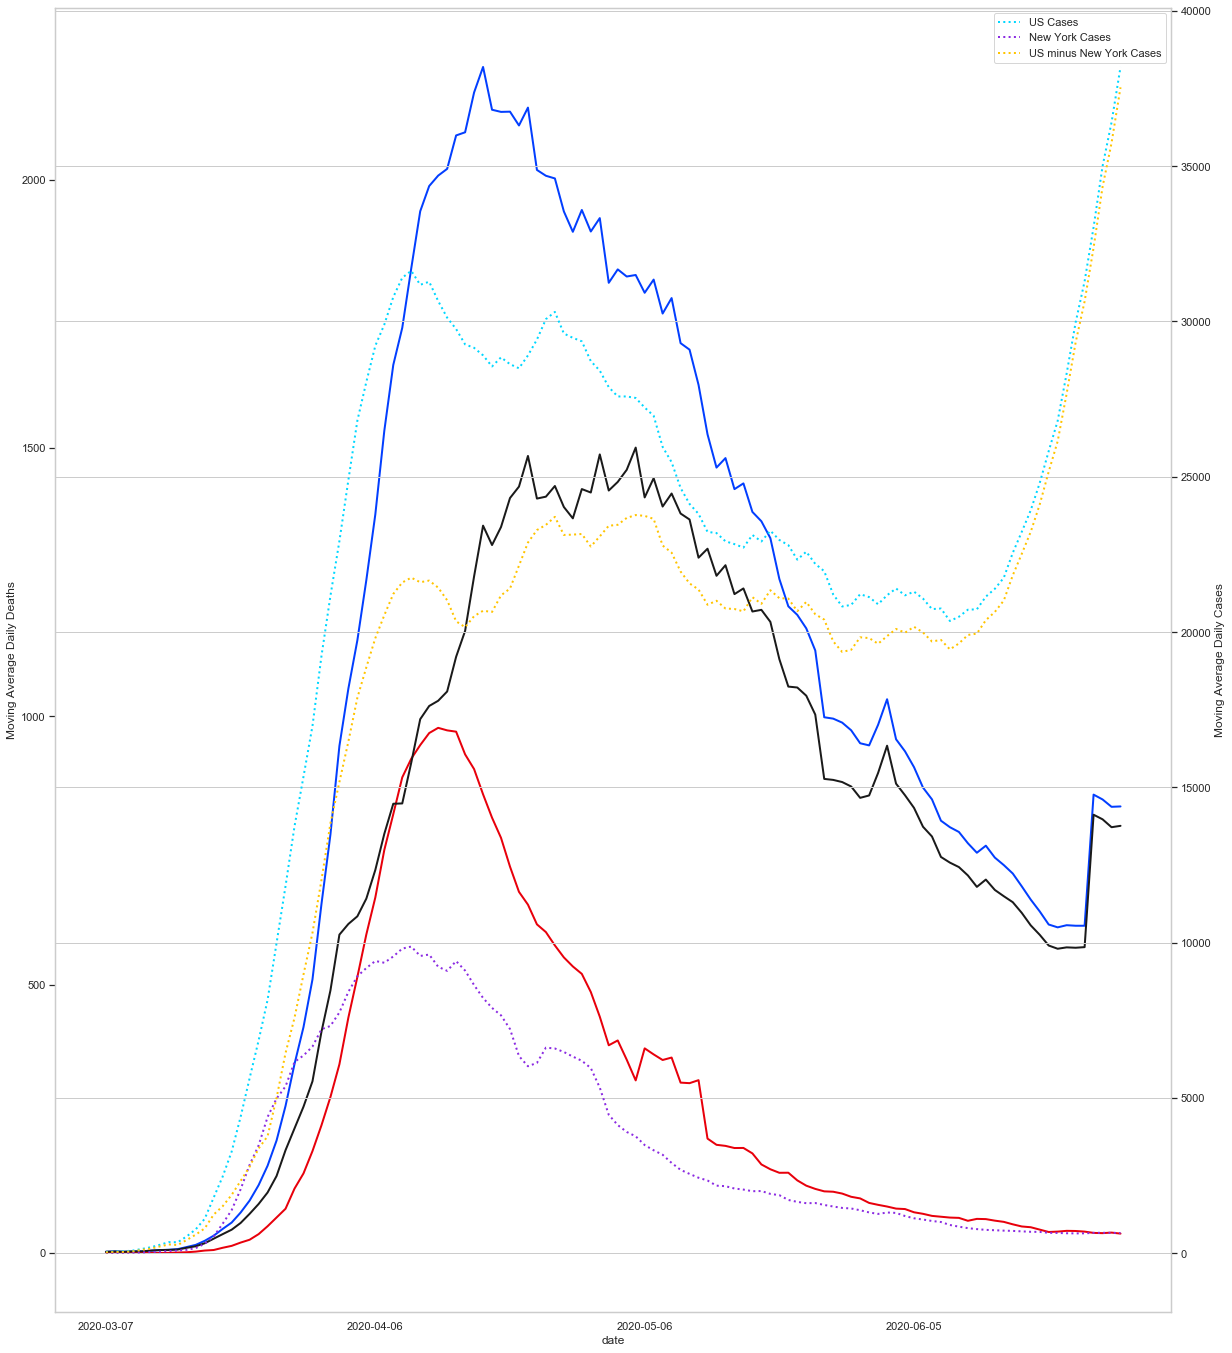

In [25]:
fig, ax = plt.subplots(1,1)
tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams.update({'font.size': 10})
label_markings = ax.get_xticklabels()
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

plt.rcParams.update({'font.size': 14})
us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US'), tri_state.loc['2020-03-07':].plot(ax=ax, label="New York"), 
us_minus_new_york.loc['2020-03-07':].plot(ax=ax,color='k', label="US minus New York"), plt.ylabel('Moving Average Daily Deaths'), 

all_data_cases_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Cases', secondary_y=True,linestyle=":"), 
tri_state_cases.loc['2020-03-07':].plot(ax=ax, label="New York Cases", secondary_y=True,linestyle=":"),  
us_minus_new_york_cases.loc['2020-03-07':].plot(ax=ax, label="US minus New York Cases", secondary_y=True,linestyle=":"), plt.legend(), plt.ylabel('Moving Average Daily Cases')
plt.setp( ax.get_xticklabels(), visible=True), plt.legend()
#deaths_intervention_adjusted_daily['Maryland'].plot(), deaths_intervention_adjusted_daily['Connecticut'].plot(), plt.legend(), plt.grid()



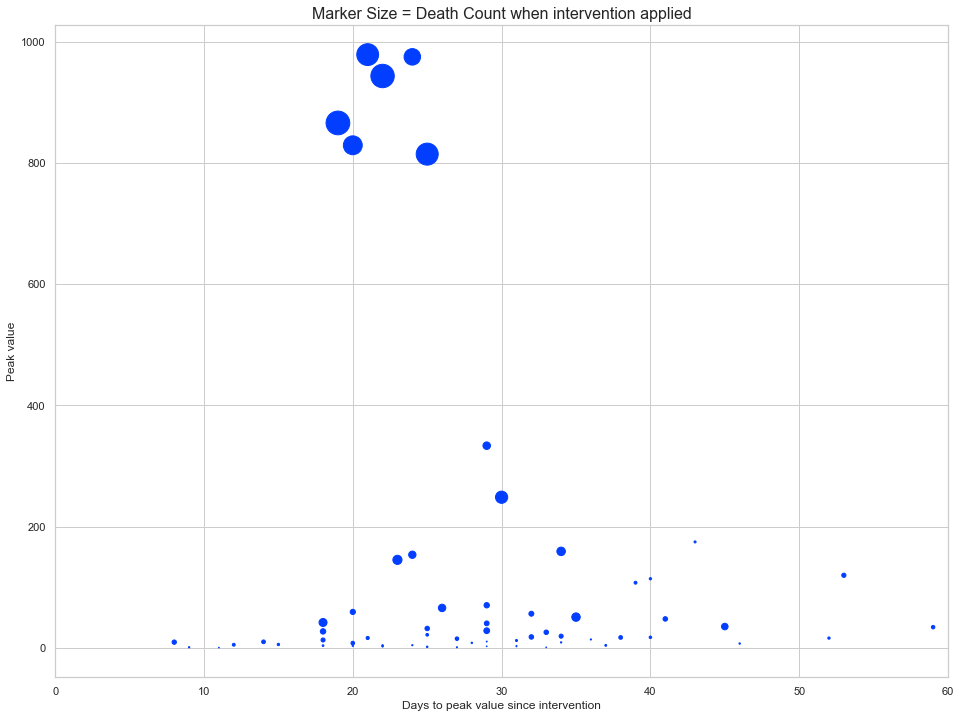

In [26]:
df = create_peak_clusters(deaths_intervention_adjusted_daily,7)
plt.figure(figsize=(16,12))
#fig, ax = plt.subplots(1,1)

plt.rcParams.update({'font.size': 12})
tick_spacing = 30
# this is a bug in matplotlib
#plt.rcParams['figure.figsize'] = (24.0, 18.0)

#label_markings = ax.get_xticklabels()
#ax.set_xticklabels(label_markings, rotation=45)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention'), plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : 16}),
plt.ylabel('Peak value'),


variablelabel = df.index

for i, txt in enumerate(variablelabel):
    if(df['peak value'][i]>3500):
        plt.annotate(txt, (df['days to peak'][i], df['peak value'][i]+20))



(<matplotlib.axes._subplots.AxesSubplot at 0x1215bb6d0>,
 <matplotlib.legend.Legend at 0x120ca13a0>)

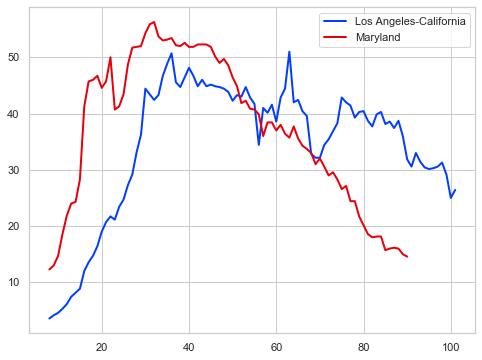

In [27]:

tick_spacing = 30
targets = ['Los Angeles-California', 'Maryland']
# this is a bug in matplotlib
df = deaths_intervention_adjusted_daily
plt.rcParams['figure.figsize'] = (8.0, 6.0)
df[targets].plot(), plt.legend()

16


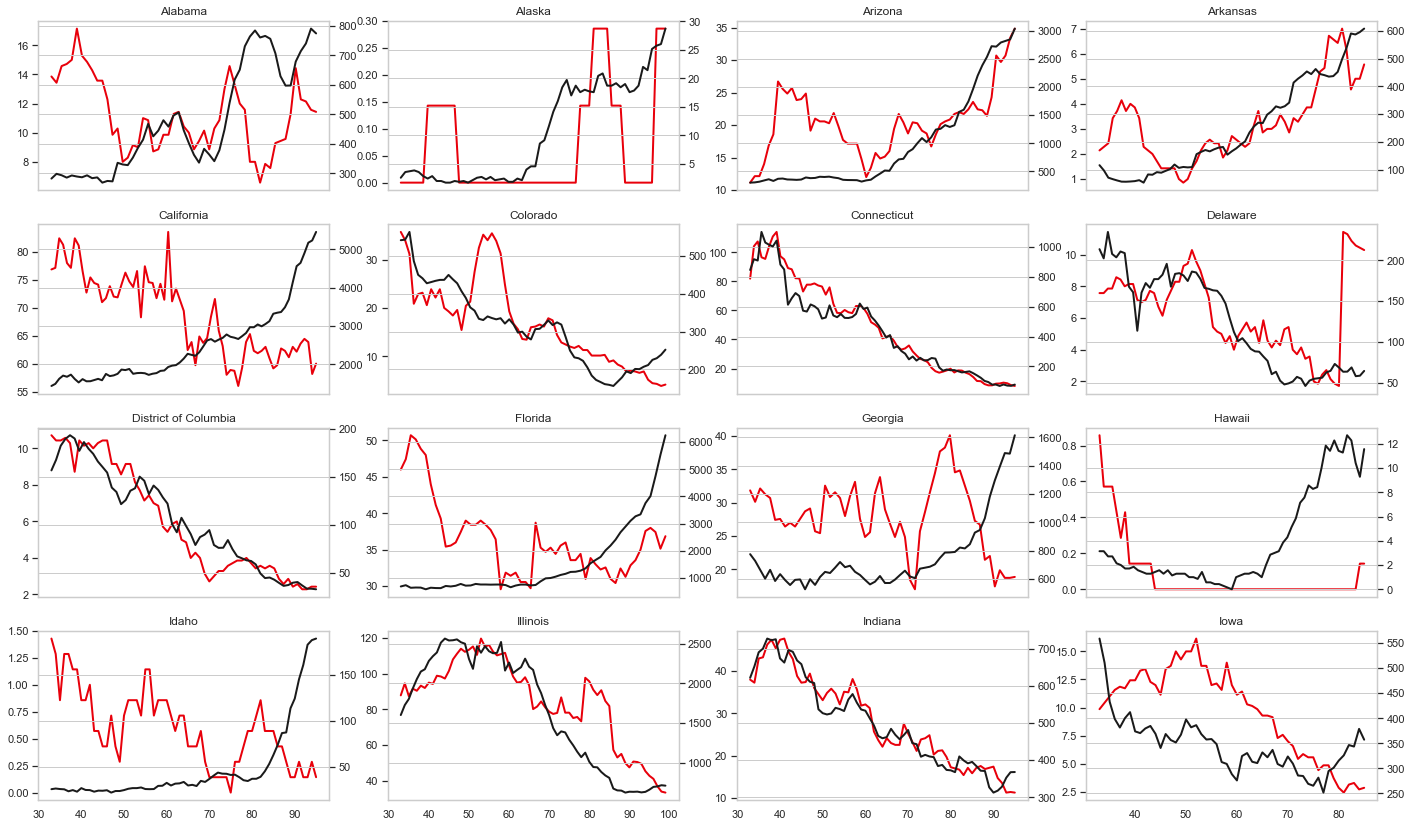

32


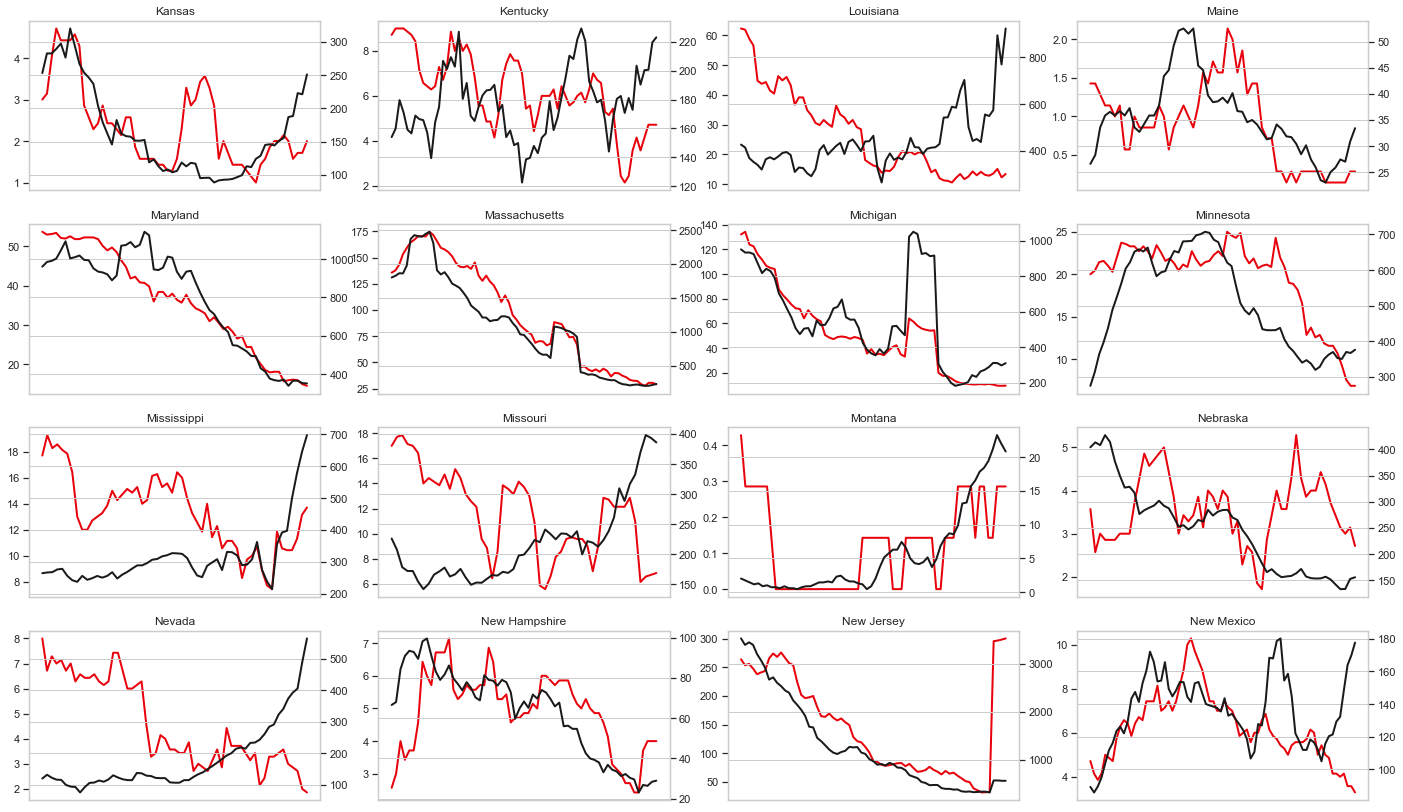

48


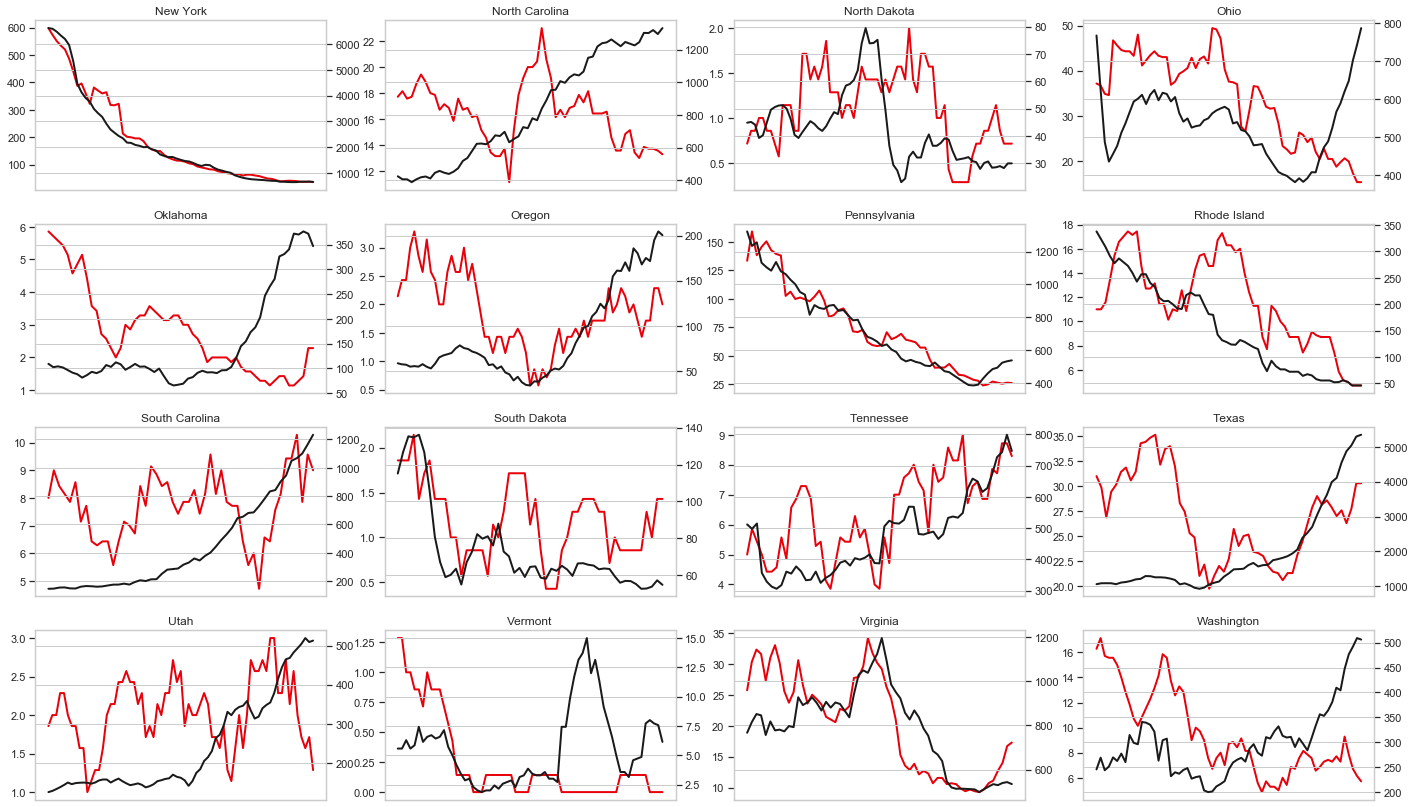

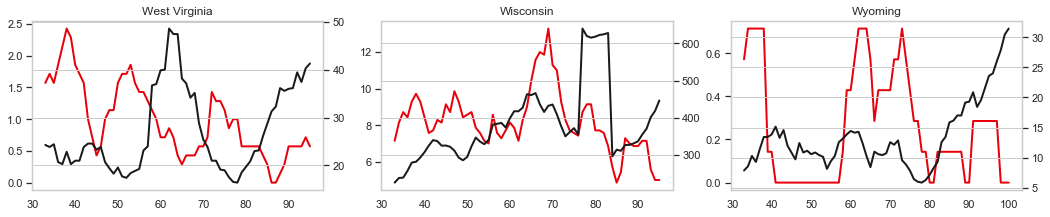

In [28]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (24.0, 48.0)

plot_target = ['Sweden', 'Belgium', 'Netherlands', 'Spain', 'New York', 'Italy', 'Florida', 'India']
plot_us = [ 'Texas', 'Illinois','Maryland', 'Indiana', 'Virginia', 'Tennessee', 'North Carolina', 'Iowa', 'Arizona',
          'Wisconsin', 'South Carolina', 'Minnesota', 'Nebraska', 'Delaware', 'Kansas', 'New Mexico', 
           'New Hampshire', 'North Dakota', 'Florida', 'Michigan','Wyoming']
plot_us=newdf.columns
newfig=[16,32,48]
for i in range(1,52):

    ax = plt.subplot(13,4, i)
    deaths_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, color='r', label='deaths')
    #plt.legend()
    
    cases_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, secondary_y=True, color='k', label='cases')
    #plt.legend()
    plt.title(plot_us[i-1])
    if i in newfig:
        print(i)
        plt.show()


In [29]:
trial = filter_data_by_intervention(all_data, google_social)

16


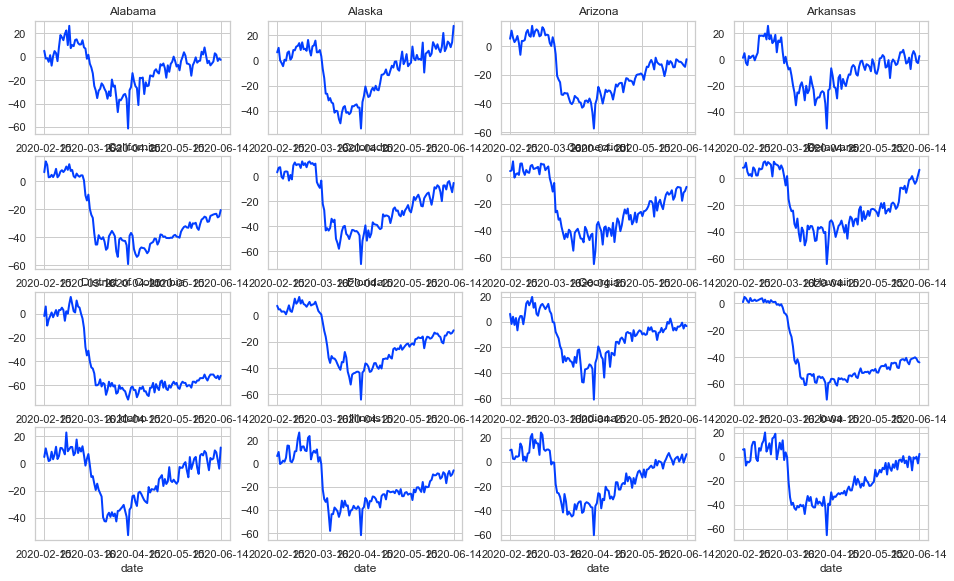

32


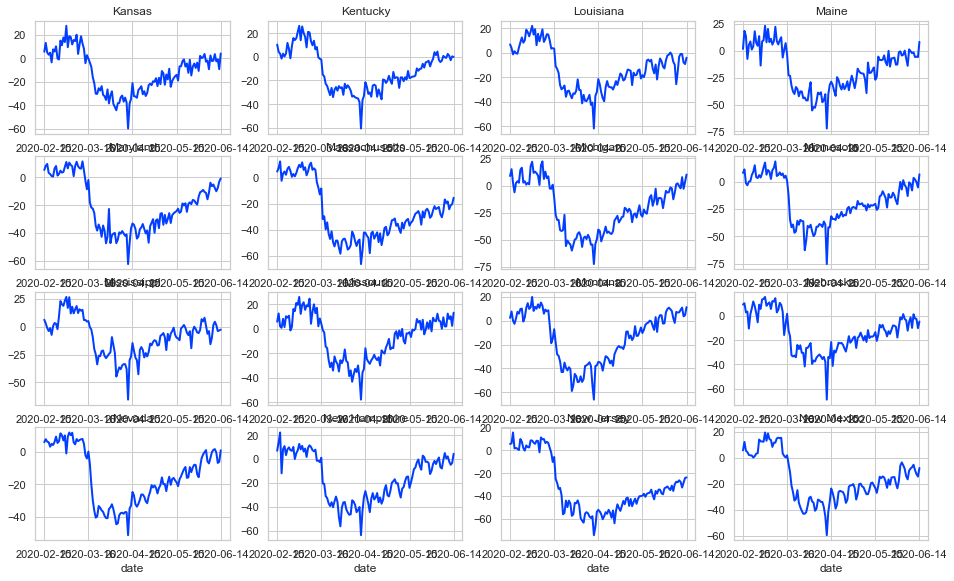

48


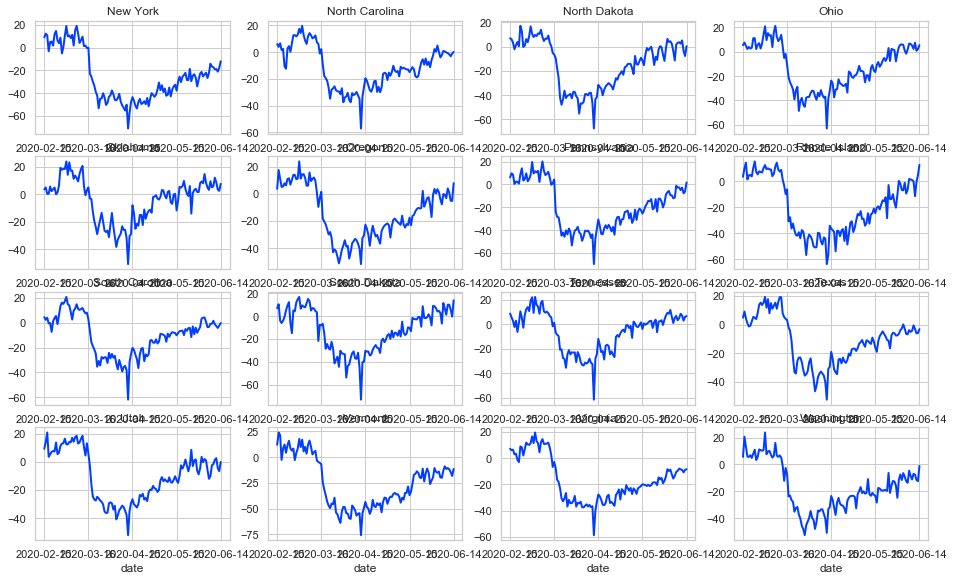

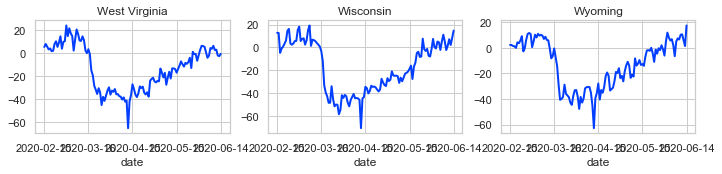

In [30]:
state_list = ['Massachusetts', 'New Jersey', 'New York', 'California', 'Washington']
state_list = newdf.columns
plt.rcParams['figure.figsize'] = (16.0, 32.0)

newfig=[16,32,48]

tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
for i in range(1,52):
    ax = plt.subplot(13,4, i)
    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


    mobility_us[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
    if i in newfig:
        print(i)
        plt.show()

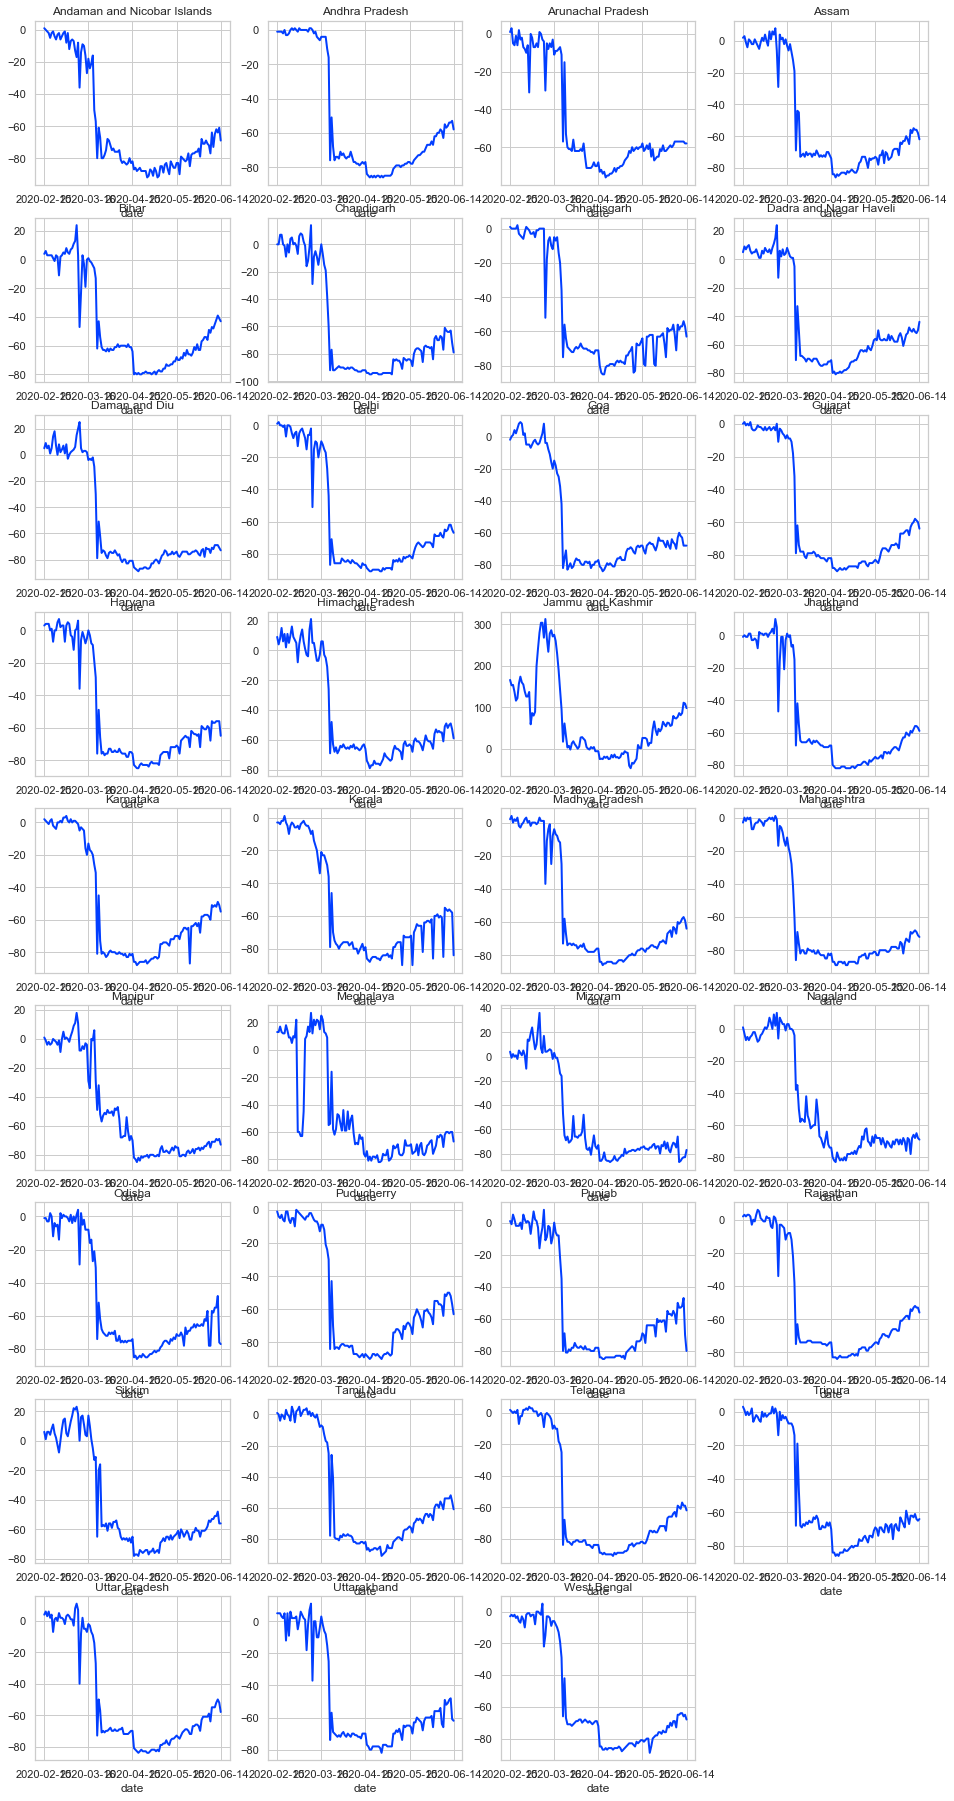

In [31]:
plt.rcParams['figure.figsize'] = (16.0, 32.0)
tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

mobility_sweden = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "India"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
state_list=mobility_sweden.columns
total_figures = len(state_list)
num_rows = np.ceil(total_figures/4)
for i in range(1, total_figures+1):
    ax = plt.subplot(num_rows,4, i)
    plt.setp( ax.get_xticklabels(), visible=True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    mobility_sweden[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
#    if i in newfig:
#        print(i)
#        plt.show()

In [32]:
us_minus_newyork = all_data_daily['US'] - all_data_daily['New York']

(<matplotlib.legend.Legend at 0x12417eca0>, None)

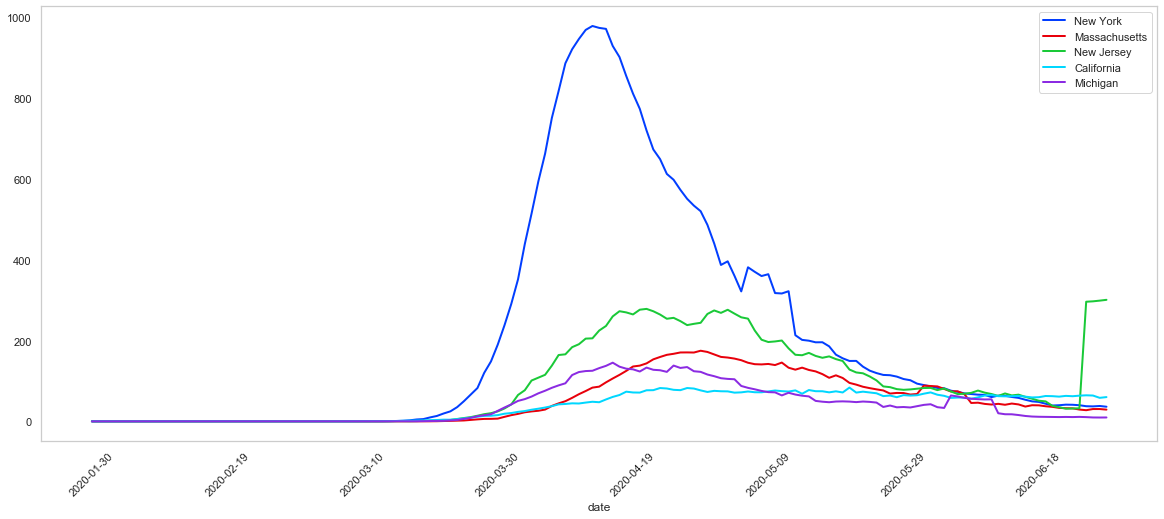

In [33]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

all_data_daily['New York'].plot(label="New York"),
all_data_daily['Massachusetts'].plot(), all_data_daily['New Jersey'].plot(),
all_data_daily['California'].plot(),
all_data_daily['Michigan'].plot(), plt.xticks(rotation=45),
plt.legend(), plt.grid()

# 

In [34]:
global_peak_size = create_peak_clusters(deaths_intervention_adjusted_daily)

In [35]:
def create_peak_clusters_date(df, threshold=5):
    df_temp = df
    df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
    df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
    df_cluster['peak value'] = df_temp.max()
    df_cluster['initial value'] = df_temp.iloc[0,:]
    df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
    global_peak_size = df_cluster.loc[df_cluster['sizes'] - df_cluster['days to peak'] > threshold]
    #plt.scatter(global_peak_size['days to peak'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']), 
    return global_peak_size

In [36]:
df_temp = all_data_daily
df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
df_cluster['peak value'] = df_temp.max()
df_cluster['initial value'] = df_temp.iloc[0,:]
df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
global_peak_size = df_cluster.loc[pd.to_datetime(df_cluster['sizes']) - pd.to_datetime(df_cluster['days to peak']) > pd.Timedelta('5 days')]

In [37]:
global_peak_size = create_peak_clusters(deaths_intervention_adjusted_daily)
global_peak_size_cases = create_peak_clusters(cases_intervention_adjusted_daily)

In [38]:
all_data_threshold = create_filtered_data(all_data, 5)

In [39]:
global_peak_size_thresh = create_peak_clusters(create_rolling_data(all_data_threshold))


In [40]:
country_population = pd.read_excel("../data/mobility/country_pop_WDI.xlsx")
county_population = pd.read_excel("../data/mobility/co-est2019-annres.xlsx", header=[3])
new = county_population['Unnamed: 0'].str.replace(".","").str.replace(" County","").str.split(pat=",", expand=True)
county_population['state']=new[1].str.strip()
state_population = county_population.groupby('state').sum()
us_state_population = pd.DataFrame()
us_state_population['Country'] = state_population.index
us_state_population['Value'] = state_population[[2019]].values

all_population = pd.concat([country_population, us_state_population], axis=0, ignore_index=True)

In [41]:
county_population

Unnamed: 0       Census  \
0                                         United States  308745538.0   
1                              .Autauga County, Alabama      54571.0   
2                              .Baldwin County, Alabama     182265.0   
3                              .Barbour County, Alabama      27457.0   
4                                 .Bibb County, Alabama      22915.0   
...                                                 ...          ...   
3144  Note: The 6,222 people in Bedford city, Virgin...          NaN   
3145                                Suggested Citation:          NaN   
3146  Annual Estimates of the Resident Population fo...          NaN   
3147    Source: U.S. Census Bureau, Population Division          NaN   
3148                           Release Date: March 2020          NaN   

      Estimates Base         2010         2011         2012         2013  \
0        308758105.0  309321666.0  311556874.0  313830990.0  315993715.0   
1            54597.0      54773.0      55227.0      54954.0      54727.0   
2           182265.0     183112.0     186558.0     190145.0     194885.0   
3            27455.0      27327.0      27341.0      27169.0      26937.0   
4            22915.0      22870.0      22745.0      22667.0      22521.0   
...              ...          ...          ...          ...          ...   
3144             NaN          NaN          NaN          NaN          NaN   
3145             NaN          NaN          NaN          NaN          NaN   
3146             NaN          NaN          NaN          NaN          NaN   
3147             NaN          NaN          NaN          NaN          NaN   
3148             NaN          NaN          NaN          NaN          NaN   

             2014         2015         2016         2017         2018  \
0     318301008.0  320635163.0  322941311.0  324985539.0  326687501.0   
1         54893.0      54864.0      55243.0      55390.0      55533.0   
2        199183.0     202939.0     207601.0     212521.0     217855.0   
3         26755.0      26283.0      25806.0      25157.0      24872.0   
4         22553.0      22566.0      22586.0      22550.0      22367.0   
...           ...          ...          ...          ...          ...   
3144          NaN          NaN          NaN          NaN          NaN   
3145          NaN          NaN          NaN          NaN          NaN   
3146          NaN          NaN          NaN          NaN          NaN   
3147          NaN          NaN          NaN          NaN          NaN   
3148          NaN          NaN          NaN          NaN          NaN   

             2019                       state  
0     328239523.0                        None  
1         55869.0                     Alabama  
2        223234.0                     Alabama  
3         24686.0                     Alabama  
4         22394.0                     Alabama  
...           ...                         ...  
3144          NaN  222 people in Bedford city  
3145          NaN                        None  
3146          NaN              2010 to July 1  
3147          NaN         Population Division  
3148          NaN                        None  

[3149 rows x 14 columns]

(<BarContainer object of 3 artists>, Text(0.5, 0, 'Population'))

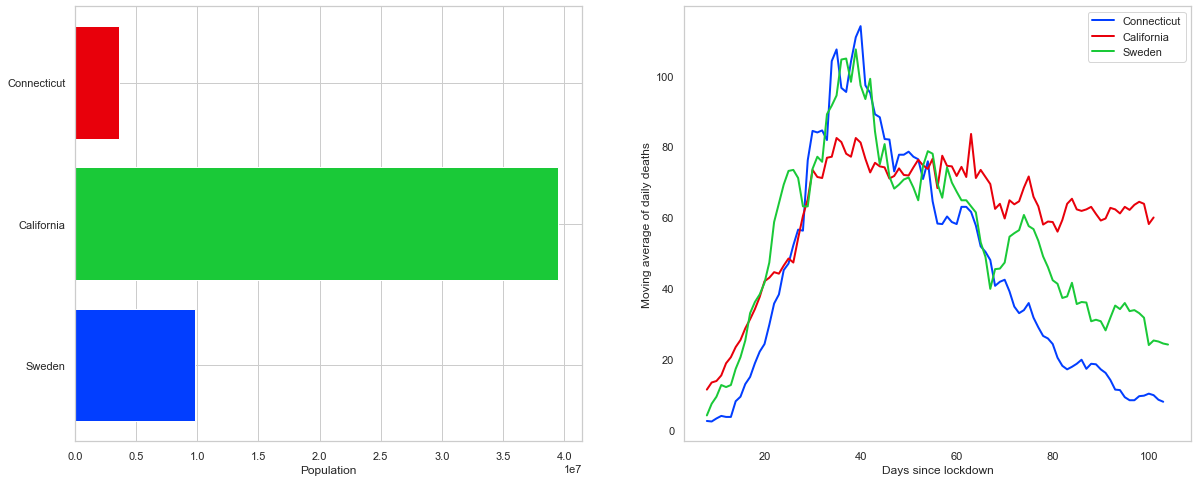

In [42]:
targets = ['Sweden', 'Denmark', 'Norway', 'Finland']
#targets = ['India', 'Russia', 'Brazil']
targets = ['Michigan', 'Netherlands']
targets = ['Connecticut', 'California', 'Sweden']

#targets = ['Austria', 'Czechia', 'Hungary']
plt.rcParams['figure.figsize'] = (20.0, 8.0)
ax = plt.subplot(1,2,2)
deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths'), plt.grid()
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population')

(<BarContainer object of 3 artists>, Text(0.5, 0, 'Population'))

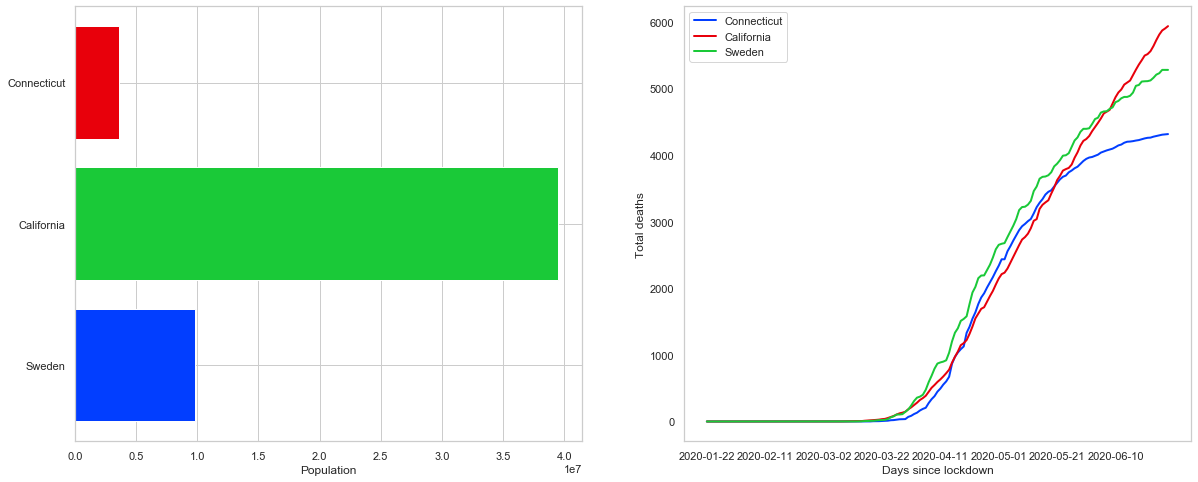

In [43]:
ax = plt.subplot(1,2,2)
all_data[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Total deaths'), plt.grid()
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population')


In [44]:
new[1].str.strip()

0                             None
1                          Alabama
2                          Alabama
3                          Alabama
4                          Alabama
                   ...            
3144    222 people in Bedford city
3145                          None
3146                2010 to July 1
3147           Population Division
3148                          None
Name: 1, Length: 3149, dtype: object

(<matplotlib.axes._subplots.AxesSubplot at 0x120f93190>, None)

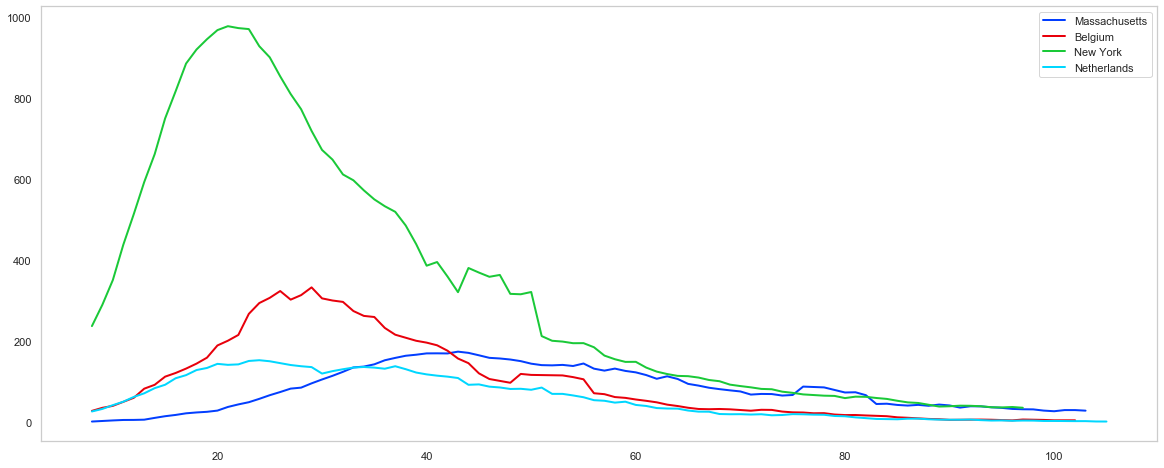

In [45]:
targets = ['Massachusetts', 'Belgium', 'New York', 'Netherlands']
deaths_intervention_adjusted_daily[targets].plot(), plt.grid()

In [46]:
deaths_peak = list(global_peak_size.index)
cases_peak = list(global_peak_size_cases.index)
common_places = set(deaths_peak).intersection(cases_peak)
common_places2 = list(set(global_peak_size.index) & set(global_peak_size_cases.index))

In [47]:
global_peak_size['lags'] = global_peak_size.loc[common_places2, "days to peak"]-global_peak_size_cases.loc[common_places2, "days to peak"]

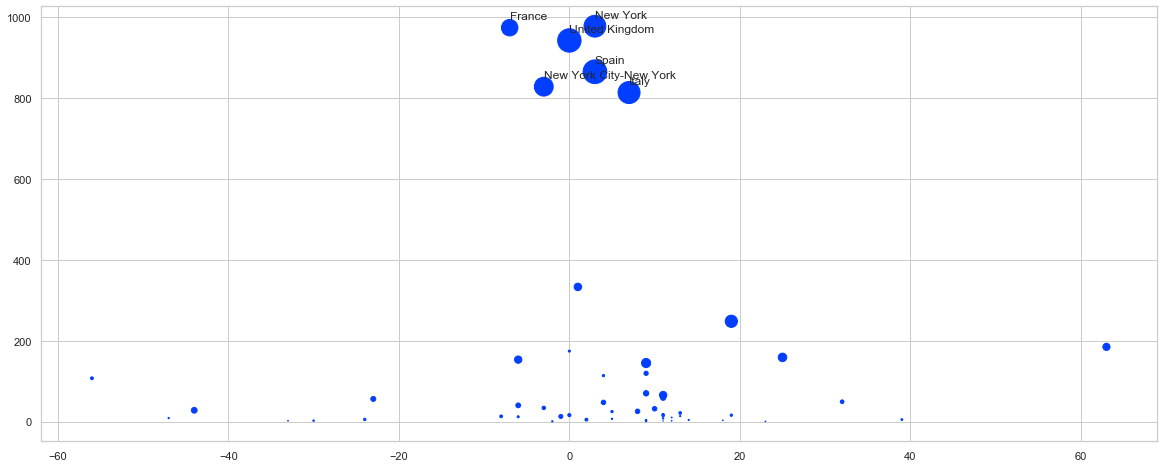

In [48]:
plt.scatter(global_peak_size['lags'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']),
variablelabel = global_peak_size.index

for i, txt in enumerate(variablelabel):
    if(global_peak_size['peak value'][i]>500):
        plt.annotate(txt, (global_peak_size['lags'][i], global_peak_size['peak value'][i]+20))

        variablelabel = global_peak_size.index


<Figure size 1152x864 with 0 Axes>

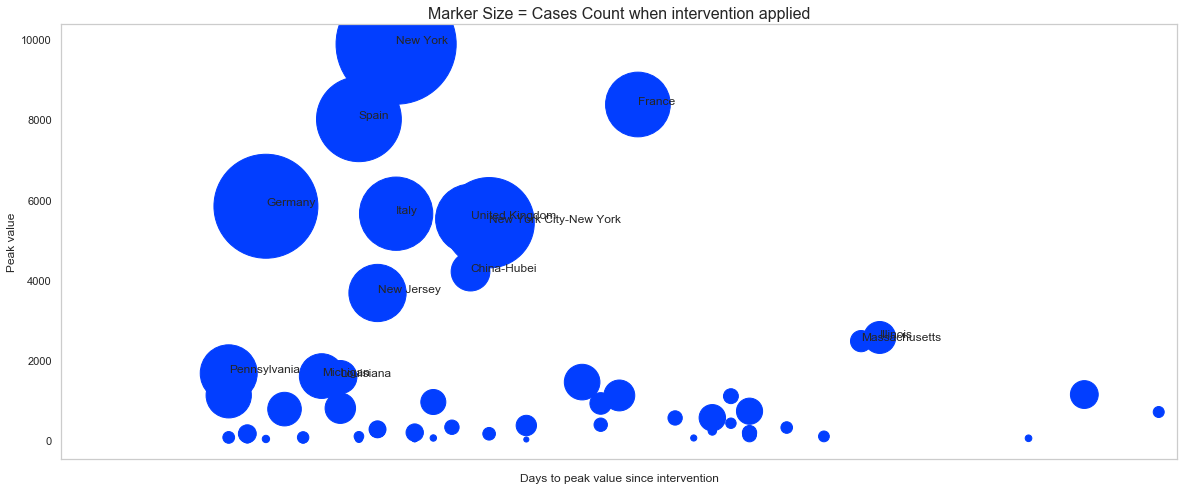

In [49]:
plt.figure(figsize=(16,12))
fig, ax = plt.subplots(1,1)


tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (16.0, 12.0)

label_markings = ax.get_xticklabels()
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(global_peak_size_cases['days to peak'], (global_peak_size_cases['peak value']), s=2*global_peak_size_cases['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention'), plt.title('Marker Size = Cases Count when intervention applied', fontdict = {'fontsize' : 16}), plt.ylabel('Peak value'), plt.grid()
variablelabel = global_peak_size_cases.index

for i, txt in enumerate(variablelabel):
    if(global_peak_size_cases['peak value'][i]>1500):
        plt.annotate(txt, (global_peak_size_cases['days to peak'][i], global_peak_size_cases['peak value'][i]+20))

        variablelabel = global_peak_size.index

(array([20., 14.,  7., 10.,  1.,  3.,  3.,  2.,  2.,  1.]),
 array([ 9. , 17.6, 26.2, 34.8, 43.4, 52. , 60.6, 69.2, 77.8, 86.4, 95. ]),
 <a list of 10 Patch objects>)

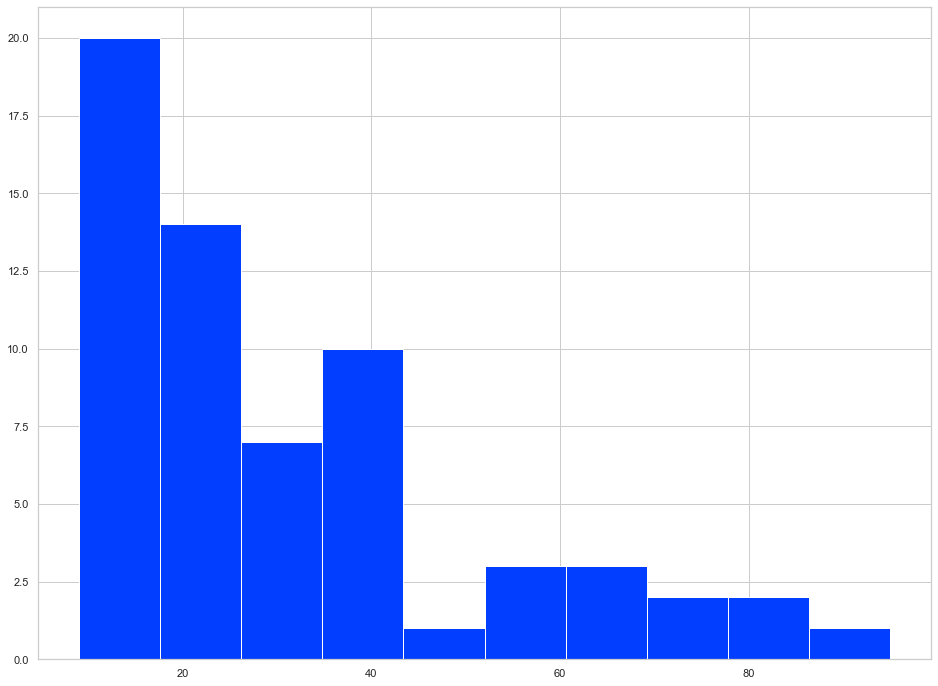

In [50]:
plt.hist(global_peak_size_cases['days to peak'])

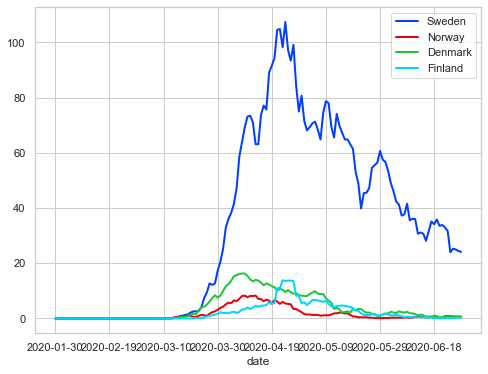

In [51]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)

all_data_daily[['Sweden', 'Norway', 'Denmark', 'Finland']].plot()

In [60]:
population_dict = dict(zip(state_population.index, state_population[[2019]].values.flatten()))

state_list = newdf.columns

tmp = {}
for state in population_dict: 
    if state in state_list:
        tmp[state] = population_dict[state]
        
population_dict = tmp
print(population_dict)

staggered_pop = [[],[],[],[],[]]
min_pop = np.float('inf')
max_pop = 0
for state in population_dict: 
    if population_dict[state] < min_pop:
        min_pop = population_dict[state]
    if population_dict[state] > max_pop:
        max_pop = population_dict[state]
        
print(min_pop, max_pop)





    

{'Alabama': 4903185.0, 'Alaska': 731545.0, 'Arizona': 7278717.0, 'Arkansas': 3017804.0, 'California': 39512223.0, 'Colorado': 5758736.0, 'Connecticut': 3565287.0, 'Delaware': 973764.0, 'District of Columbia': 705749.0, 'Florida': 21477737.0, 'Georgia': 10617423.0, 'Hawaii': 1415872.0, 'Idaho': 1787065.0, 'Illinois': 12671821.0, 'Indiana': 6732219.0, 'Iowa': 3155070.0, 'Kansas': 2913314.0, 'Kentucky': 4467673.0, 'Louisiana': 4648794.0, 'Maine': 1344212.0, 'Maryland': 6045680.0, 'Massachusetts': 6892503.0, 'Michigan': 9986857.0, 'Minnesota': 5639632.0, 'Mississippi': 2976149.0, 'Missouri': 6137428.0, 'Montana': 1068778.0, 'Nebraska': 1934408.0, 'Nevada': 3080156.0, 'New Hampshire': 1359711.0, 'New Jersey': 8882190.0, 'New Mexico': 2096829.0, 'New York': 19453561.0, 'North Carolina': 10488084.0, 'North Dakota': 762062.0, 'Ohio': 11689100.0, 'Oklahoma': 3956971.0, 'Oregon': 4217737.0, 'Pennsylvania': 12801989.0, 'Rhode Island': 1059361.0, 'South Carolina': 5148714.0, 'South Dakota': 884659

In [61]:
groups = 5
pop = np.linspace(start = min_pop, stop = max_pop, num = groups)
all_populations = []
for i in range(groups-1): 
    all_populations.append({})
for state in population_dict:
    for i in range(groups-1):
        if pop[i] <= population_dict[state] <= pop[i+1]:
            all_populations[i][state] = population_dict[state]
            
print(all_populations)

[{'Alabama': 4903185.0, 'Alaska': 731545.0, 'Arizona': 7278717.0, 'Arkansas': 3017804.0, 'Colorado': 5758736.0, 'Connecticut': 3565287.0, 'Delaware': 973764.0, 'District of Columbia': 705749.0, 'Hawaii': 1415872.0, 'Idaho': 1787065.0, 'Indiana': 6732219.0, 'Iowa': 3155070.0, 'Kansas': 2913314.0, 'Kentucky': 4467673.0, 'Louisiana': 4648794.0, 'Maine': 1344212.0, 'Maryland': 6045680.0, 'Massachusetts': 6892503.0, 'Michigan': 9986857.0, 'Minnesota': 5639632.0, 'Mississippi': 2976149.0, 'Missouri': 6137428.0, 'Montana': 1068778.0, 'Nebraska': 1934408.0, 'Nevada': 3080156.0, 'New Hampshire': 1359711.0, 'New Jersey': 8882190.0, 'New Mexico': 2096829.0, 'North Dakota': 762062.0, 'Oklahoma': 3956971.0, 'Oregon': 4217737.0, 'Rhode Island': 1059361.0, 'South Carolina': 5148714.0, 'South Dakota': 884659.0, 'Tennessee': 6829174.0, 'Utah': 3205958.0, 'Vermont': 623989.0, 'Virginia': 8535519.0, 'Washington': 7614893.0, 'West Virginia': 1792147.0, 'Wisconsin': 5822434.0, 'Wyoming': 578759.0}, {'Georg

16


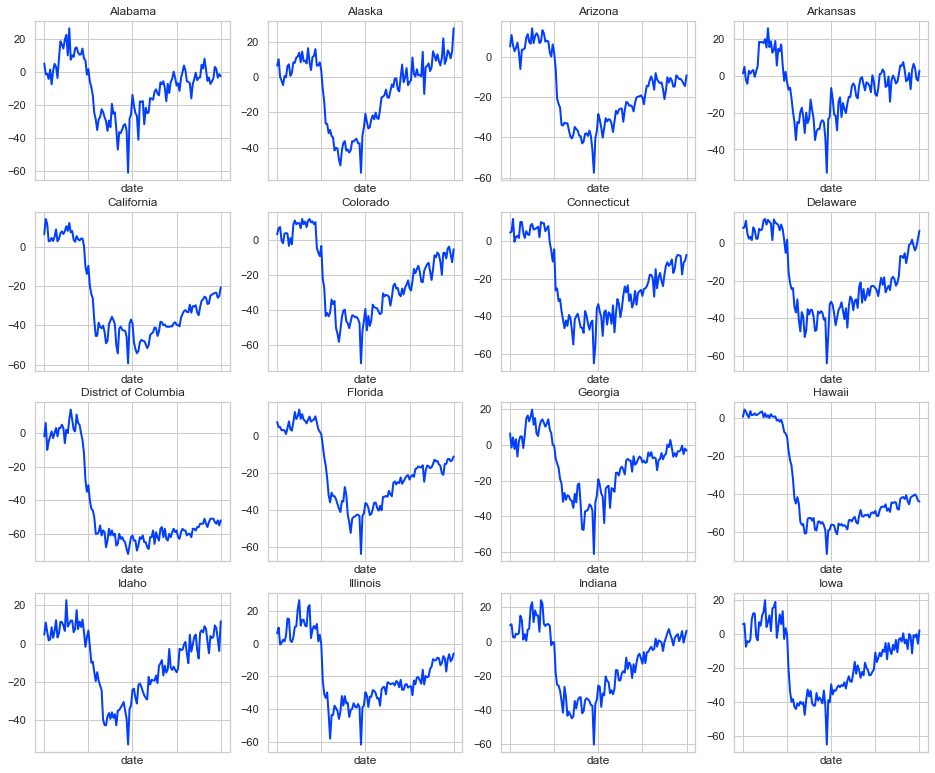

32


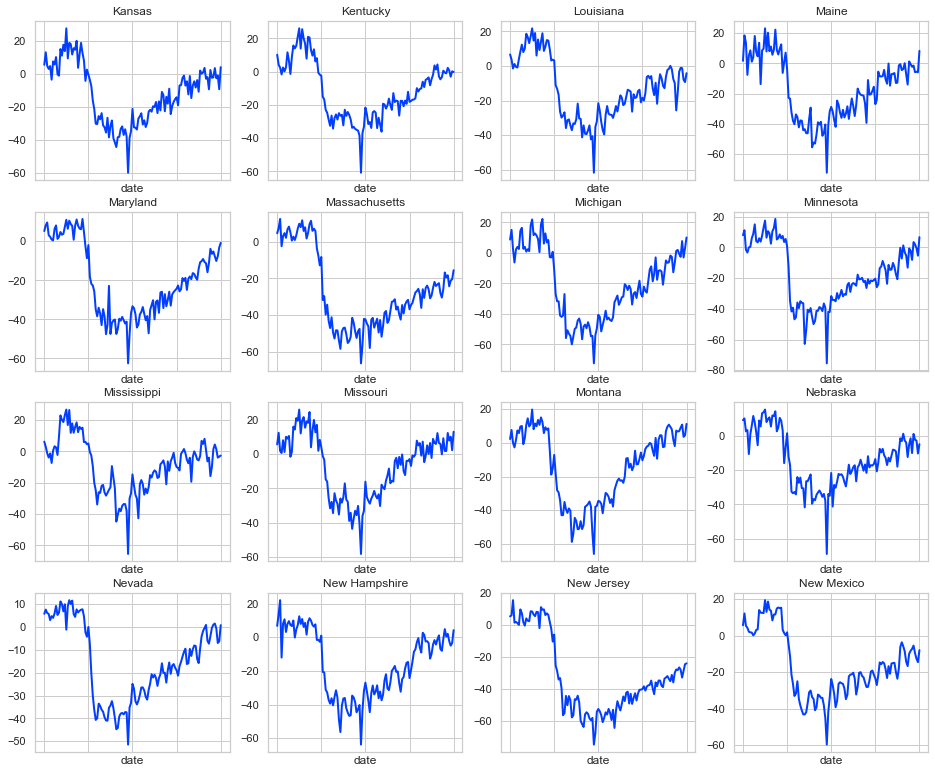

48


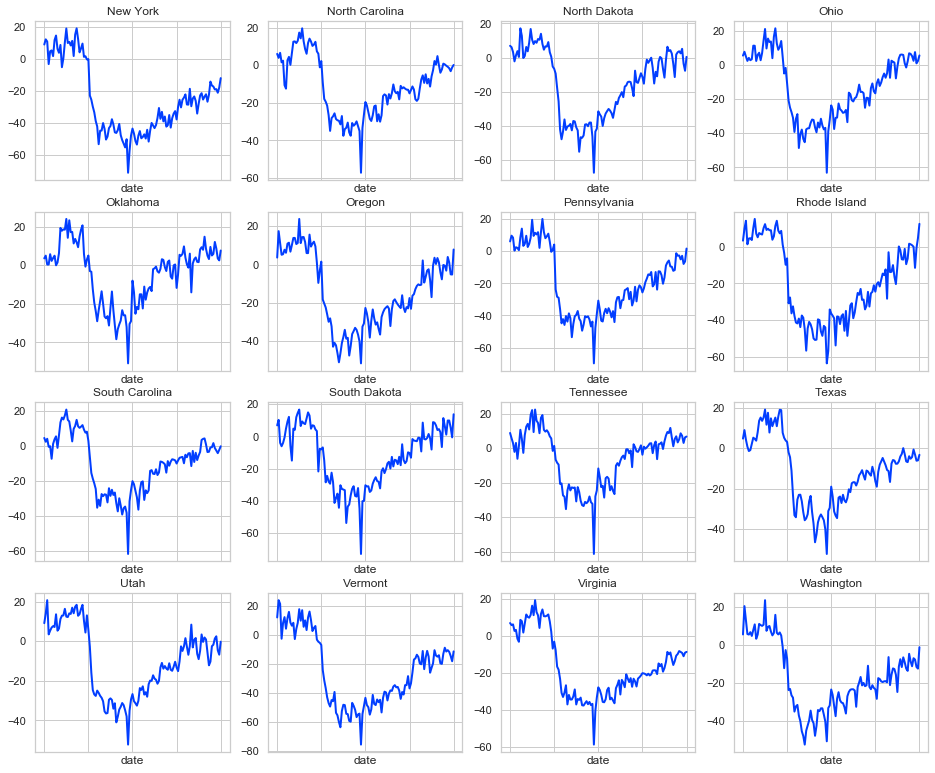

[('Alabama', datetime.datetime(2020, 5, 28, 0, 0)), ('Alaska', datetime.datetime(2020, 5, 4, 0, 0)), ('Arizona', datetime.datetime(2020, 2, 17, 0, 0)), ('Arkansas', datetime.datetime(2020, 5, 28, 0, 0)), ('California', datetime.datetime(2020, 5, 20, 0, 0)), ('Colorado', datetime.datetime(2020, 6, 12, 0, 0)), ('Connecticut', datetime.datetime(2020, 6, 9, 0, 0)), ('Delaware', datetime.datetime(2020, 6, 8, 0, 0)), ('District of Columbia', datetime.datetime(2020, 2, 17, 0, 0)), ('Florida', datetime.datetime(2020, 5, 6, 0, 0)), ('Georgia', datetime.datetime(2020, 4, 29, 0, 0)), ('Hawaii', datetime.datetime(2020, 2, 17, 0, 0)), ('Idaho', datetime.datetime(2020, 5, 26, 0, 0)), ('Illinois', datetime.datetime(2020, 5, 31, 0, 0)), ('Indiana', datetime.datetime(2020, 5, 20, 0, 0)), ('Iowa', datetime.datetime(2020, 6, 12, 0, 0)), ('Kansas', datetime.datetime(2020, 6, 2, 0, 0)), ('Kentucky', datetime.datetime(2020, 5, 26, 0, 0)), ('Louisiana', datetime.datetime(2020, 6, 11, 0, 0)), ('Maine', dateti

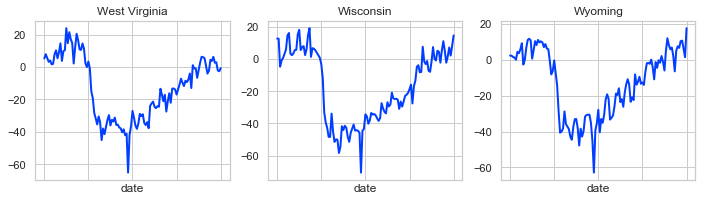

In [62]:
# threshold lower (absolute value higher) for higher populations?
# let's say threshold for each group jumps by -10

#state_list = ['Massachusetts', 'New Jersey', 'New York', 'California', 'Washington']
state_list = newdf.columns
plt.rcParams['figure.figsize'] = (16.0, 45.0)

newfig=[16,32,48]

tick_spacing = 30
#print((state_list))

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
states_reopenings = []
for i in range(1,52):
    ax = plt.subplot(13,4, i)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.setp( ax.get_xticklabels(), visible=False)

    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    mobility_us[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
    count = 0 
    max_days = 3
    for j in range(groups-1):
        if state_list[i-1] in all_populations[j]:
            min_mobility = (j+1)*(-10)
            break
    end_date = -1
    for (date, value) in list(zip(mobility_us[state_list[i-1]].index,mobility_us[state_list[i-1]])):
        if value < min_mobility:
            count = 0
        elif value >= min_mobility:
            count += 1
        if count == max_days:
            end_date = date
    
    states_reopenings.append((state_list[i-1], datetime.datetime.strptime(end_date,'%Y-%m-%d')))
    #print(end_date, mobility_us[state_list[i-1]].index[0], mobility_us[state_list[i-1]].index[-1])
    
    if i in newfig:
        print(i)
        plt.show()

print(states_reopenings)


In [63]:
_, lockdown_dates = find_lockdown_date(state_list, uscases, mobility_us, max_days = 3, min_mobility = -20)


In [64]:
# find intervention dates for each state
# count how many days after that lockdown happens -> low_thresh
# use states with higher number of days to predict the ones with lower and vice versa
states_low_thresh = {}
for (state,date) in states_reopenings: # for state in lockdown_dates:
    try:
        #date = lockdown_dates[state] 
        states_low_thresh[state] = (date - pd.to_datetime(intervention_date_case[state])).days
        if states_low_thresh[state] < 0 or states_low_thresh[state] > 50:
            states_low_thresh[state] = 50
         
    except:
        continue
        


reopening_delta = {}
for (state, date) in states_reopenings:
    try:
        reopening_delta[state] = (date - lockdown_dates[state]).days
    except:
        continue
        
print(reopening_delta) 


opened_states = []
closed_states = []
max_days = 40
min_days = 30


for state in reopening_delta:
    if reopening_delta[state] >= max_days or reopening_delta[state] < 0 :
        # less than zero for the ones which have not yet opened. 
        closed_states.append(state)
        #elif reopening_delta[state] >= min_days:
    else:
        opened_states.append(state)
    

print(opened_states)
print(closed_states)


{'Alabama': 67, 'Alaska': 44, 'Arizona': -32, 'Arkansas': 66, 'California': 61, 'Colorado': 85, 'Connecticut': 82, 'Delaware': 80, 'District of Columbia': -28, 'Florida': 45, 'Georgia': 37, 'Hawaii': -32, 'Idaho': 61, 'Illinois': 73, 'Indiana': 61, 'Iowa': 85, 'Kansas': 72, 'Kentucky': 66, 'Louisiana': 81, 'Maine': 82, 'Maryland': 86, 'Massachusetts': -31, 'Michigan': 81, 'Minnesota': 81, 'Mississippi': 81, 'Missouri': 53, 'Montana': 59, 'Nebraska': 80, 'Nevada': 74, 'New Hampshire': 74, 'New Jersey': -31, 'New Mexico': 80, 'New York': 82, 'North Carolina': 42, 'North Dakota': 80, 'Ohio': 56, 'Oklahoma': 66, 'Oregon': 74, 'Pennsylvania': 74, 'Rhode Island': 87, 'South Carolina': 67, 'South Dakota': 59, 'Tennessee': 50, 'Texas': 31, 'Utah': 81, 'Vermont': -31, 'Virginia': 80, 'Washington': -31, 'West Virginia': 67, 'Wisconsin': 63, 'Wyoming': 66}
['Georgia', 'Texas']
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',

In [65]:
if not os.path.exists('../Figures/COVID/'):
    os.makedirs('../Figures/COVID/')

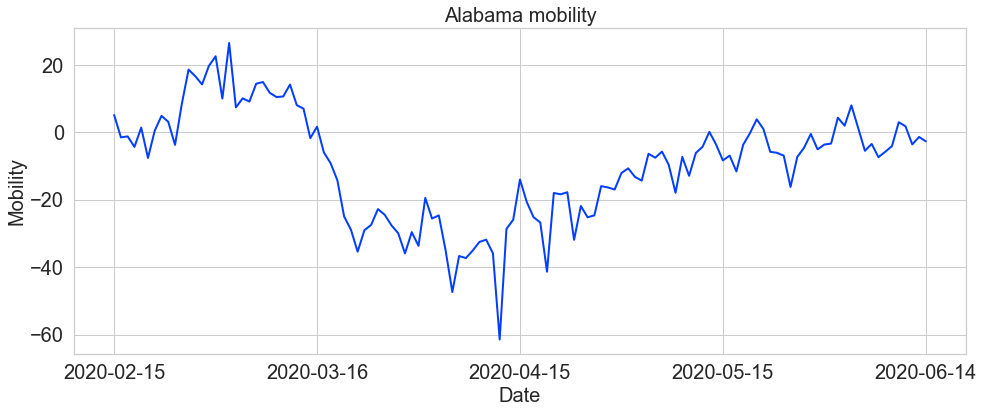

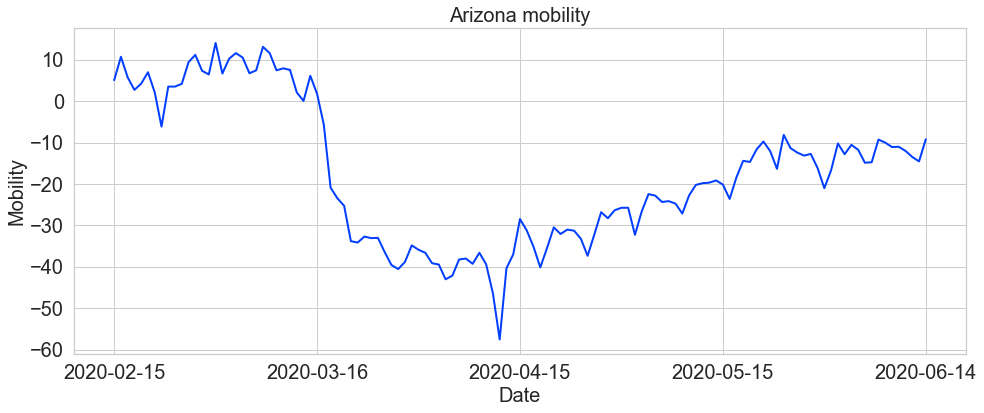

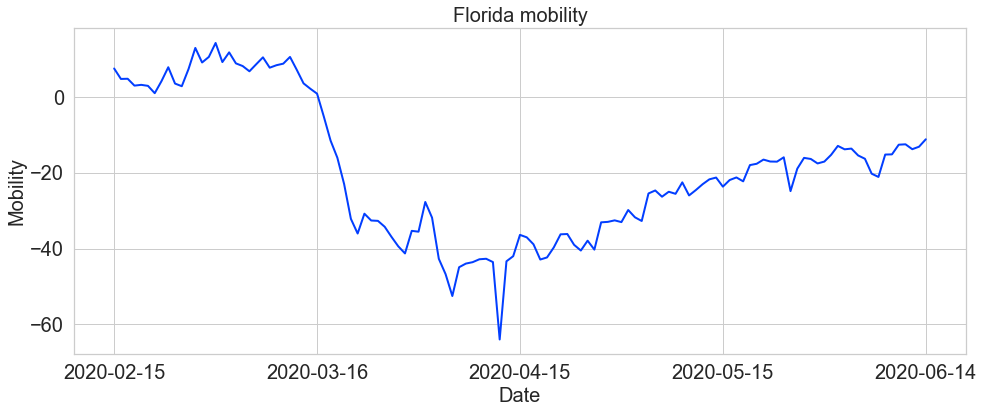

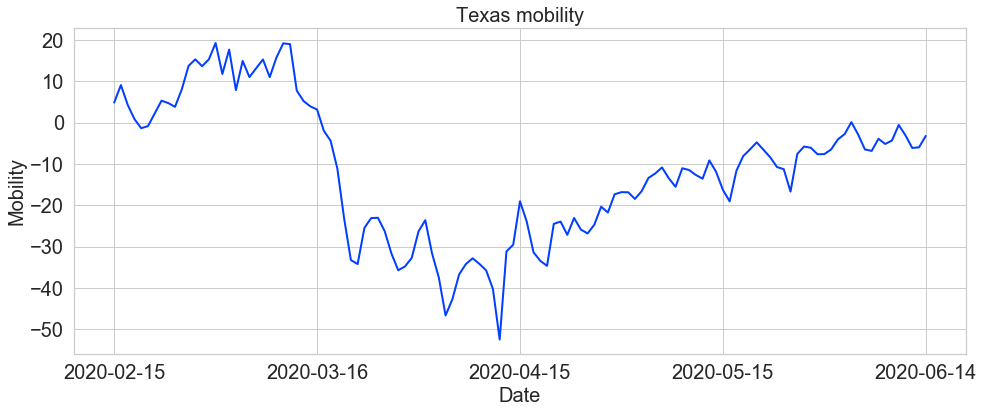

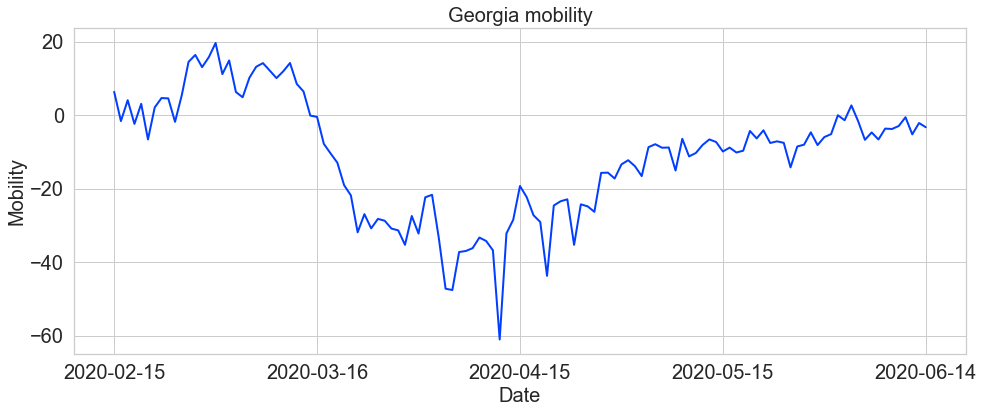

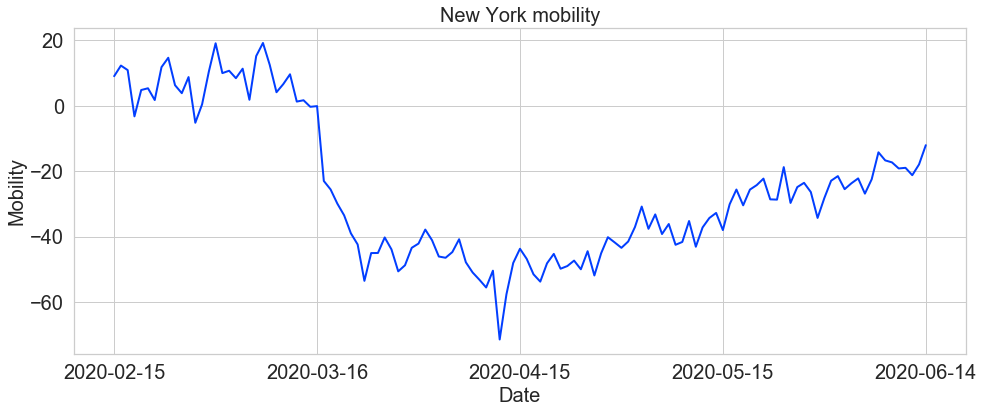

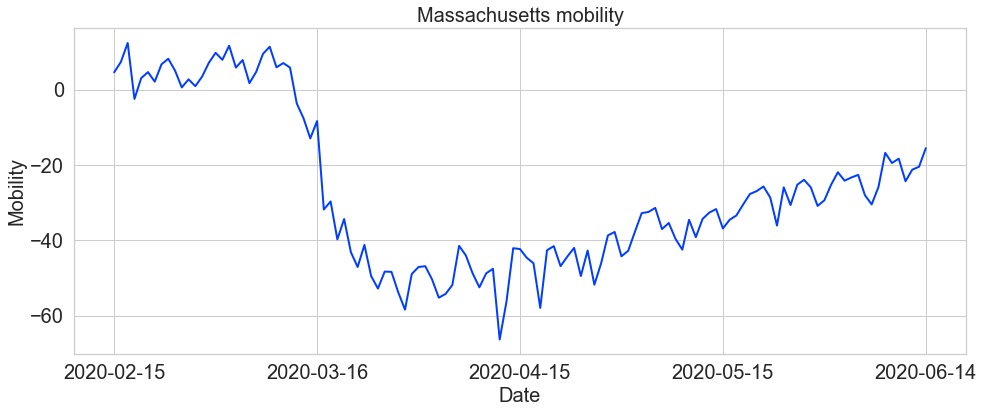

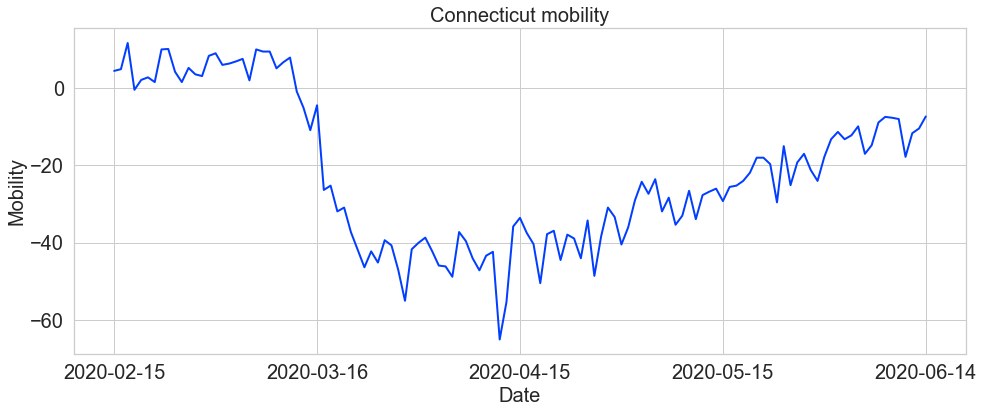

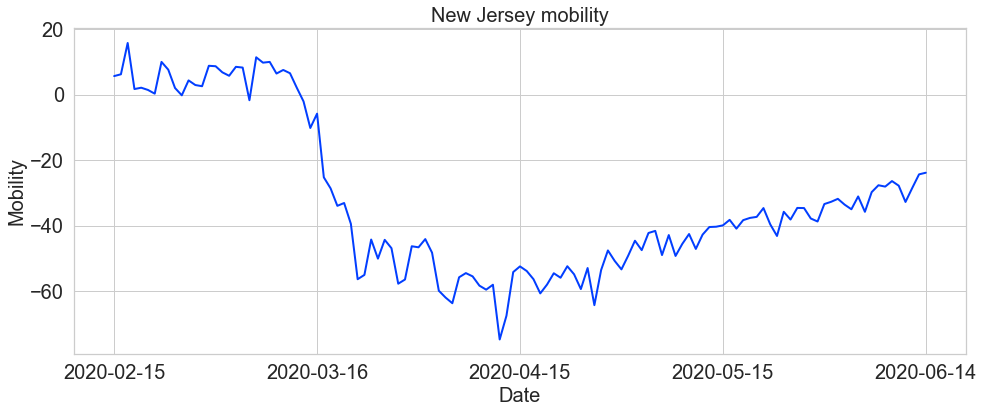

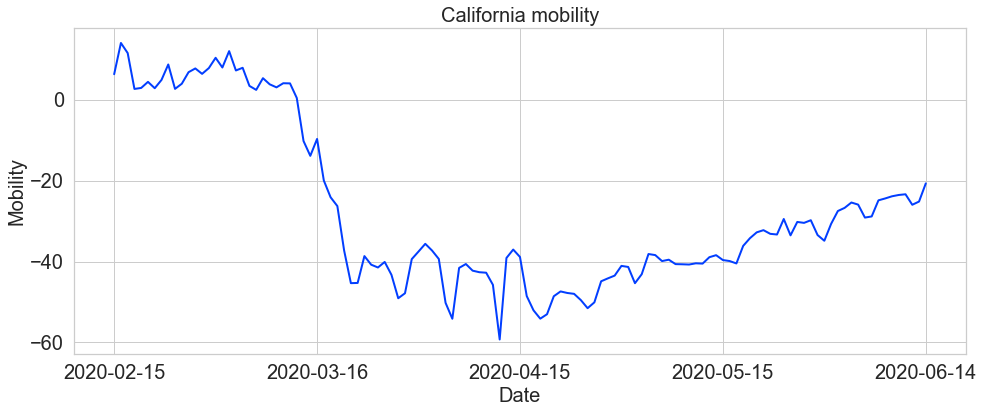

In [66]:
population_dict = dict(zip(state_population.index, state_population[[2019]].values.flatten()))
state_list =  targets #['Arizona','Texas', 'New Jersey','Alabama', 'Delaware', 'Maine', 'Wisconsin', 'New York','Washington', 'Florida', 'Georgia', 'Massachusetts','Connecticut']
plt.rcParams['figure.figsize'] = (16.0, 6.0)

FONTSIZE = 20

newfig=[16,32,48]

tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
for i in range(len(state_list)):
    '''
    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('date')
    ax1.set_ylabel('mobility over population', color=color)
    
    ax1.tick_params(axis='y', labelcolor=color)
    (mobility_us[state_list[i]]/population_dict[state_list[i]]*100000.).plot(ax=ax1, color = color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'r'
    ax2.set_ylabel('mobility', color=color)  # we already handled the x-label with ax1
    mobility_us[state_list[i]].plot(ax=ax2, color = color)
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.set_yscale('log')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    #plt.xlim(xmin = 3)
    plt.title(state_list[i] + ' mobility', fontsize=20)
    #savefig('['+','.join(map(str, sorted_dist))+']_%s_%s_rate_reg.png'%(cap,idx), bbox_inches='tight', dpi = 300)
    #plt.xlim([1,4])
    plt.savefig("../Figures/COVID/"+state_list[i]+"_mobility.png")

    plt.show()
    '''
    

    ax = plt.subplot(1,1, 1)
    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    state_mobility =  mobility_us[state_list[i]]# mobility_us[state_list[i]].rolling(10).mean()
    
    state_mobility.plot(ax=ax)
    
    
    plt.tick_params(axis='both', which='major', labelsize=FONTSIZE)

    
    plt.title(state_list[i] + ' mobility', fontsize=20)
    plt.xlabel('Date', fontsize=FONTSIZE)
    plt.ylabel('Mobility', fontsize=FONTSIZE)

    plt.savefig("../Figures/COVID/"+state_list[i]+"_mobility.png")
    plt.show()
    



['Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Alabama']
(50, 88)
Alabama 0.6763131497131705


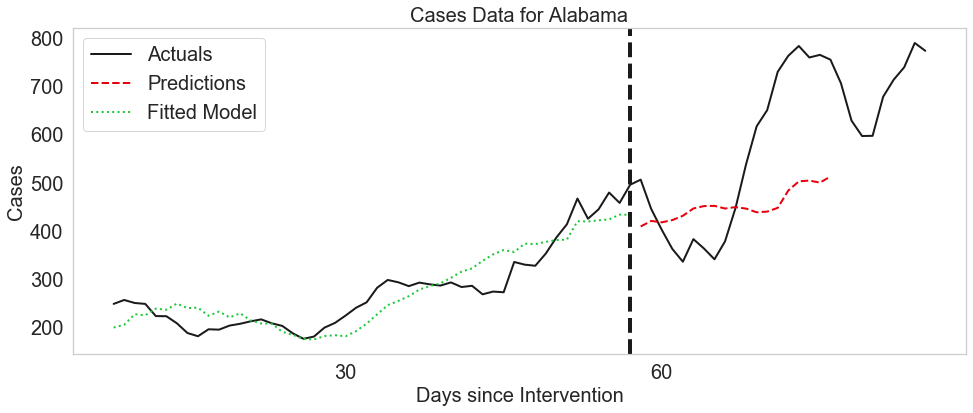

['Alabama', 'Alaska', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Arizona']
(50, 88)
Arizona 0.3009277971597506


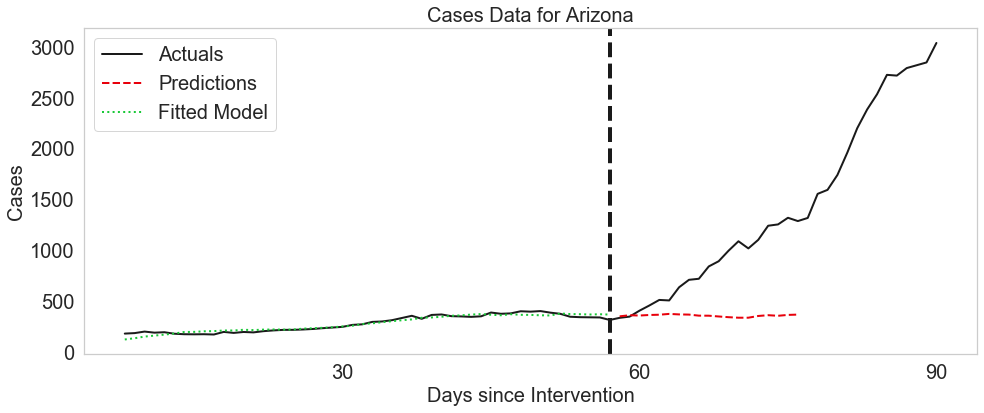

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Florida']
(33, 88)
Florida 1.338162399506332


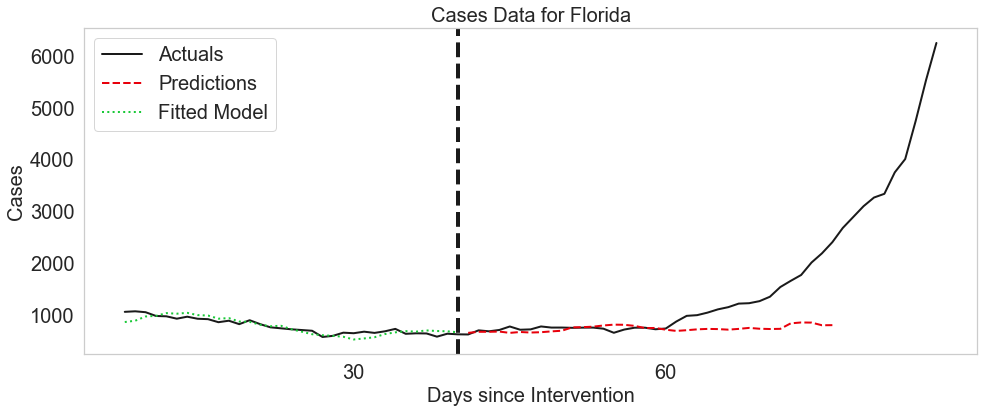

Florida 1.338162399506332
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Texas']
(20, 88)
Texas 0.6443178561155237


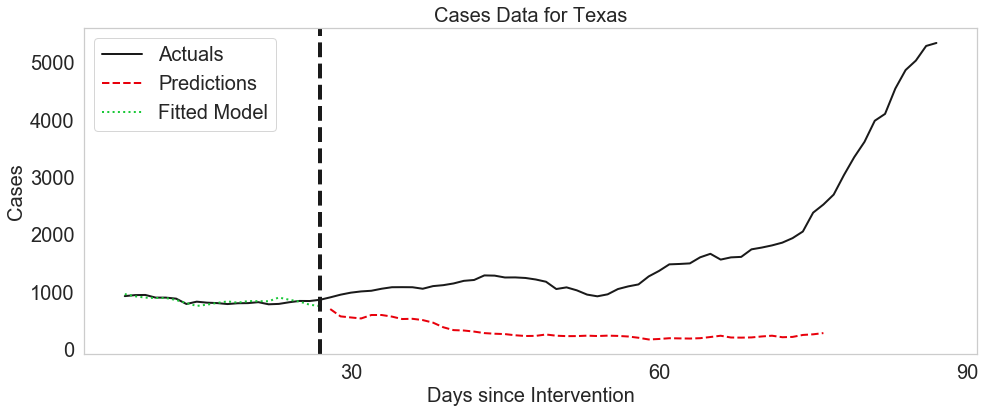

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Georgia']
(26, 88)
Georgia 1.062746258947417


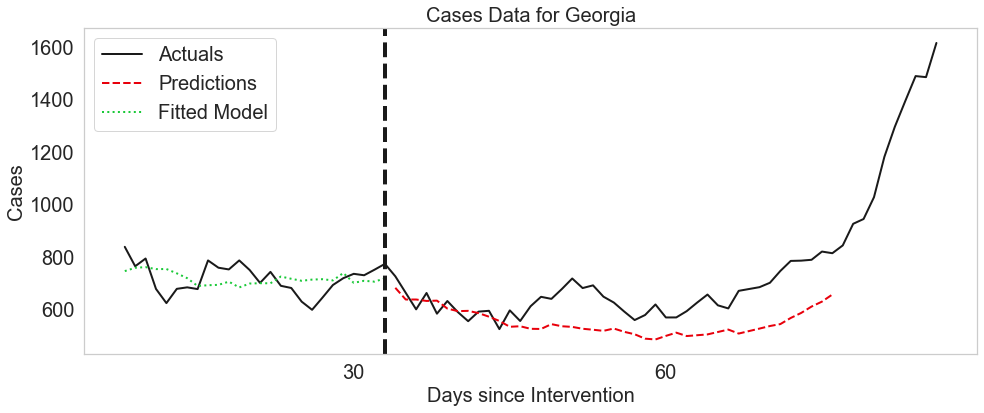

Georgia 1.062746258947417
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['New York']
(50, 88)
New York 6.547467096569778


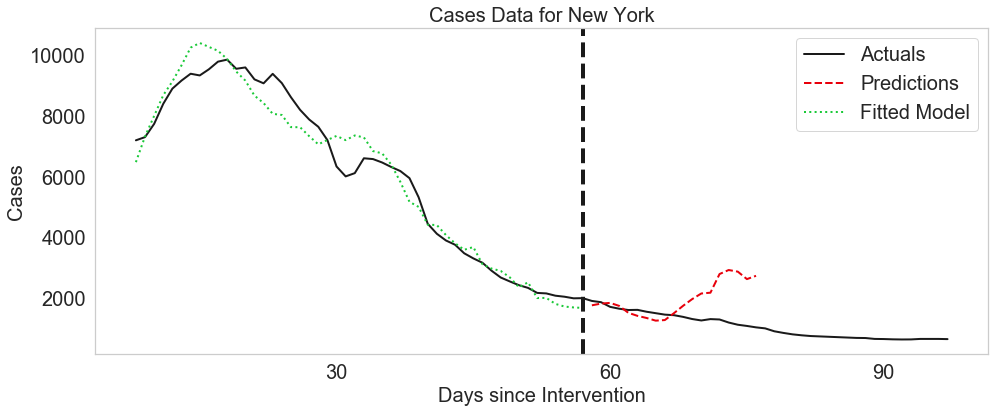

New York 6.547467096569778
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Massachusetts']
(50, 88)
Massachusetts 2.8031959519868206


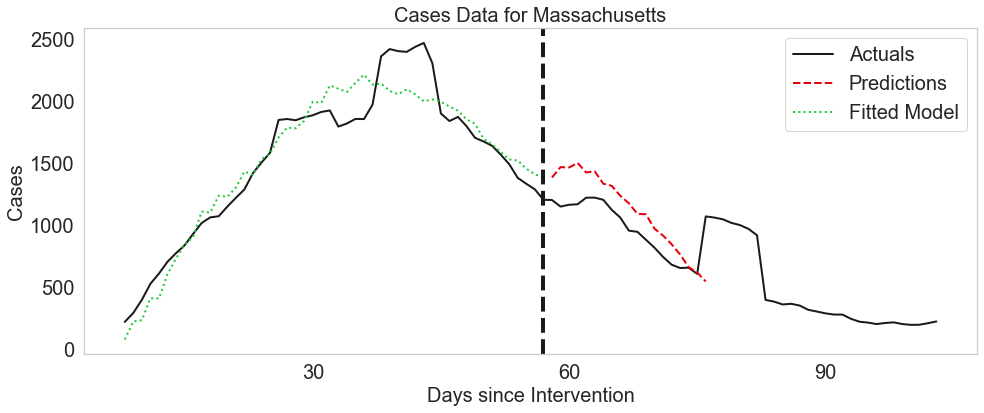

Massachusetts 2.8031959519868206
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Connecticut']
(50, 88)
Connecticut 1.7350554934247904


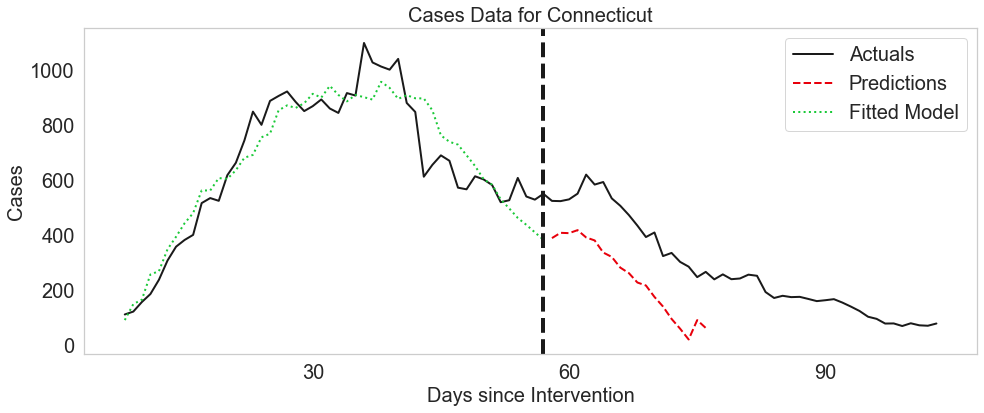

Connecticut 1.7350554934247904
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['New Jersey']
(50, 88)
New Jersey 2.4030611999655163


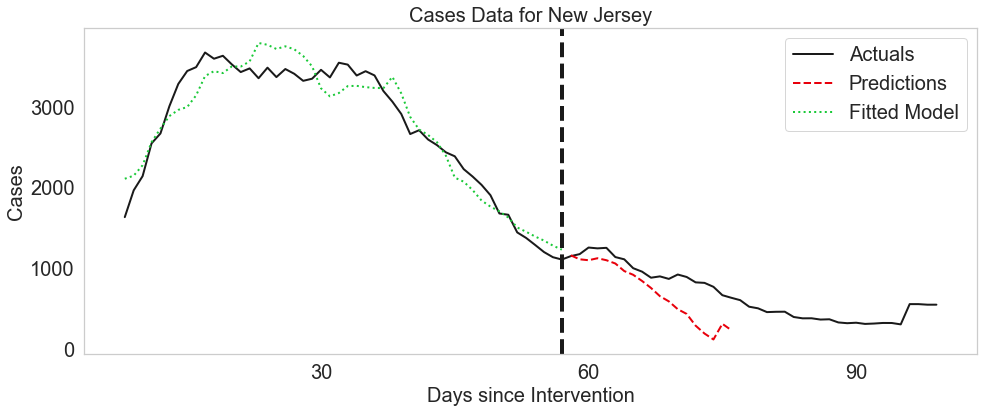

New Jersey 2.4030611999655163
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['California']
(50, 88)
California 1.7219233655452328


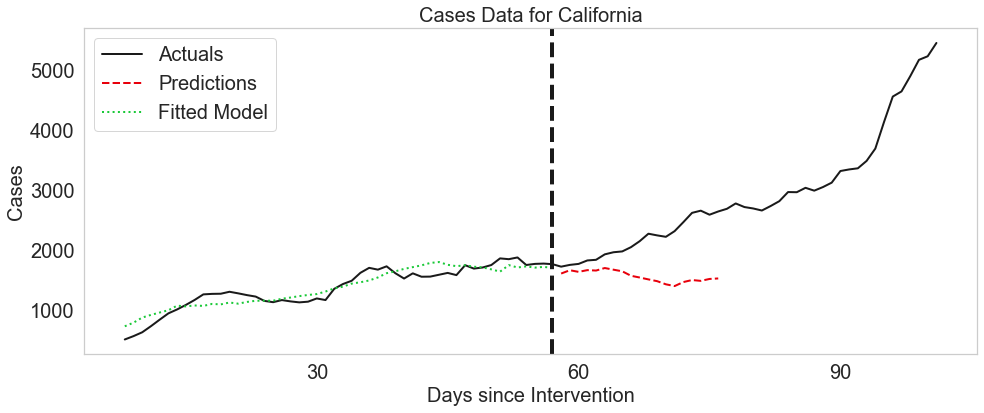

California 1.7219233655452328


In [67]:
singVals = 3

targets = ['Alabama','Arizona', 'Florida', 'Texas', 'Georgia', 'New York', 'Massachusetts', 'Connecticut', 'New Jersey', 'California']
move_intervention = 10
for target in targets:
    fig, axes = plt.subplots(figsize=(16, 6))
    camera = Camera(fig)
    '''
    new_value = synth_control_predictions([cases_intervention_adjusted_daily],70,states_low_thresh[target], "Cases Data", singVals, ylimit=[], 
                                          savePlots=True, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, donorPool=closed_states, showDonors=False, silent=False )
    '''
    new_value = synth_control_predictions([cases_intervention_adjusted_daily], 70,states_low_thresh[target], "Cases Data", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target], showstates=10,
                                   exclude=[target], figure=fig, axes=axes, svdSpectrum=False, donorPool=closed_states, showDonors=False, silent=False)#, showPlots=True) 
    
    #animation = camera.animate(interval=300)
#HTML(animation.to_html5_video())
#animation.save('../animations/'+target+' predictions.mp4')
#temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, move_intervention)
        #synth_control_predictions(pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1),45,25, "Deaths Data", 
                              #singVals, ylimit=[], savePlots=False, do_only=[target+" -"+str(move_intervention)], 
                              # showstates=10, svdSpectrum=False, showDonors=False,
                              # exclude=[target])
   

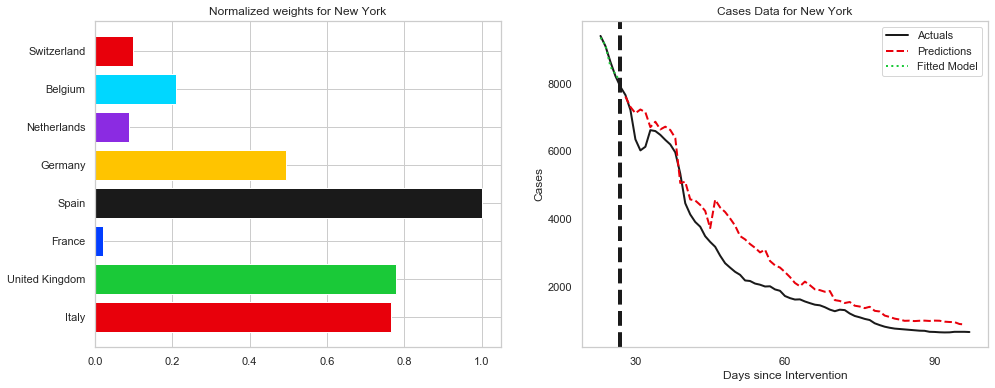

In [68]:
# Testing synth_control_predictions with noise


plt.rcParams['figure.figsize'] = (24.0, 9.0)
plt.rcParams.update({'font.size': 12})
lambdas = [1, 50]

projection_period=85
training_period=5
fig, axes = plt.subplots(1, 2, figsize=(16,6))
dist = lambda s: np.random.normal(0, 100, s)
newdata = synth_control_predictions([df1, df],projection_period, training_period, 
                                            "Cases Data", 2, ylimit=[], savePlots=False, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10, random_distribution=dist)